In [ ]:
import numpy as np  # For numerical operations and random number generation
import matplotlib.pyplot as plt  # For plotting (if needed later)
from sklearn.model_selection import train_test_split  # For splitting data (not used in this snippet)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.base import clone
import pandas as pd

# Generates a 2D dataset for binary classification with a curved decision boundary.



def generate_data(n_samples=1000, a=1.0, imbalance=False, seed=42):

    np.random.seed(seed)
    # Generate data points uniformly in the range [-3, 3]
    X = np.random.uniform(-3, 3, size=(n_samples, 2))
    # Split the feature matrix into x and y components
    x0, x1 = X[:, 0], X[:, 1]
    # Define the non-linear decision boundary: x1 = a*x0² + x0
    boundary = a * x0**2 + x0
    # Class 1 if the point is above the boundary, else class 0
    y = (x1 > boundary).astype(int)


    if imbalance:
        # Separate the indices for class 0 and class 1
        idx_class0 = np.where(y == 0)[0]
        idx_class1 = np.where(y == 1)[0]

        # Define the fraction of class 0 to keep (controls the imbalance ratio)
        keep_fraction = 0.2  # Keep only 20% of class 0 points

        # Calculate the number of class 0 points to keep
        n_class0_keep = int(len(idx_class0) * keep_fraction)
        idx_class0_keep = np.random.choice(idx_class0, n_class0_keep, replace=False)

        # Calculate how many class 0 points need to be replaced by class 1
        n_missing = len(idx_class0) - n_class0_keep

        # Generate new random points for class 1 to replace the dropped class 0 points
        X_new = np.random.uniform(-3, 3, size=(n_missing, 2))  # New random points for class 1
        x0_new, x1_new = X_new[:, 0], X_new[:, 1]
        boundary_new = a * x0_new**2 + x0_new  # Compute the boundary for new points
        y_new = (x1_new > boundary_new).astype(int)  # Assign class labels (1 for above boundary)

        # Filter out only class 1 points from the generated new points
        idx_new_class1 = np.where(y_new == 1)[0]

        # If not enough class 1 points are generated, generate more
        while len(idx_new_class1) < n_missing:
            X_more = np.random.uniform(-3, 3, size=(n_missing - len(idx_new_class1), 2))  # Additional random points
            x0_more, x1_more = X_more[:, 0], X_more[:, 1]
            boundary_more = a * x0_more**2 + x0_more  # Compute the boundary for additional points
            y_more = (x1_more > boundary_more).astype(int)  # Classify as 1 or 0 based on boundary
            X_more = X_more[y_more == 1]  # Keep only class 1 points
            X_new = np.vstack([X_new[idx_new_class1], X_more])  # Append to the original new points
            idx_new_class1 = np.arange(len(X_new))  # Reset indices after stacking new points
        else:
            X_new = X_new[idx_new_class1[:n_missing]]  # Select only the needed number of class 1 points

        # Create class 1 labels for the new points
        y_new = np.ones(len(X_new), dtype=int)  # All new points are class 1

        # Combine the selected class 0 points, original class 1 points, and new class 1 points
        X = np.vstack([X[idx_class0_keep], X[idx_class1], X_new])
        y = np.concatenate([y[idx_class0_keep], y[idx_class1], y_new])

    return X, y # Return the features and the labels

In [ ]:
X, y = generate_data(n_samples=500, a=0.5, imbalance=False)

print("Feature matrix (first 5 rows):")
print(X[:5])  # Print first 5 data points

print("\nLabels (first 20):")
print(y[:20])  # Print first 20 labels


Feature matrix (first 5 rows):
[[-0.75275929  2.70428584]
 [ 1.39196365  0.59195091]
 [-2.06388816 -2.06403288]
 [-2.65149833  2.19705687]
 [ 0.60669007  1.24843547]]

Labels (first 20):
[1 0 0 1 1 1 0 0 1 0 0 0 1 1 0 0 1 0 0 0]


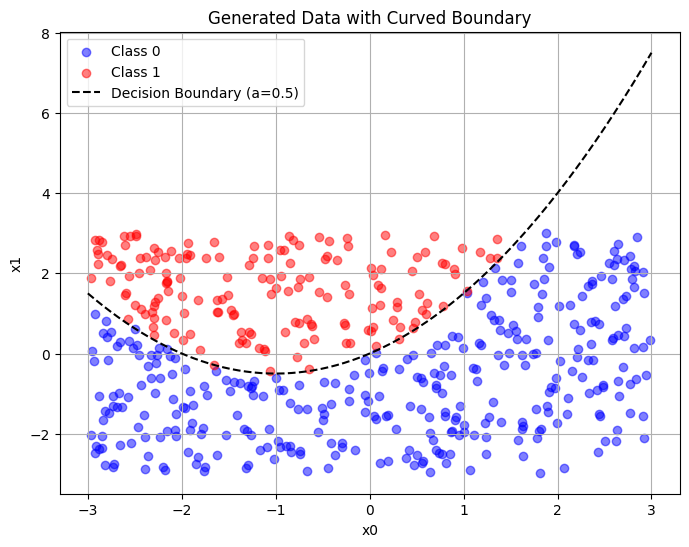

In [ ]:
def plot_data(X, y, a):
    x0 = X[:, 0]
    x1 = X[:, 1]

    plt.figure(figsize=(8, 6))
    plt.scatter(x0[y == 0], x1[y == 0], color='blue', label='Class 0', alpha=0.5)
    plt.scatter(x0[y == 1], x1[y == 1], color='red', label='Class 1', alpha=0.5)

    # Plot the true decision boundary
    x_curve = np.linspace(-3, 3, 300)
    y_curve = a * x_curve**2 + x_curve
    plt.plot(x_curve, y_curve, 'k--', label=f'Decision Boundary (a={a})')

    plt.xlabel("x0")
    plt.ylabel("x1")
    plt.title("Generated Data with Curved Boundary")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_data(X, y, a=0.5)


Feature matrix (first 5 rows):
[[ 1.9080886   2.1643835 ]
 [-2.84093214  0.51465349]
 [ 1.00851082 -1.77009423]
 [ 0.1957036  -1.54517698]
 [ 0.91176756 -1.65438414]]

Labels (first 20):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


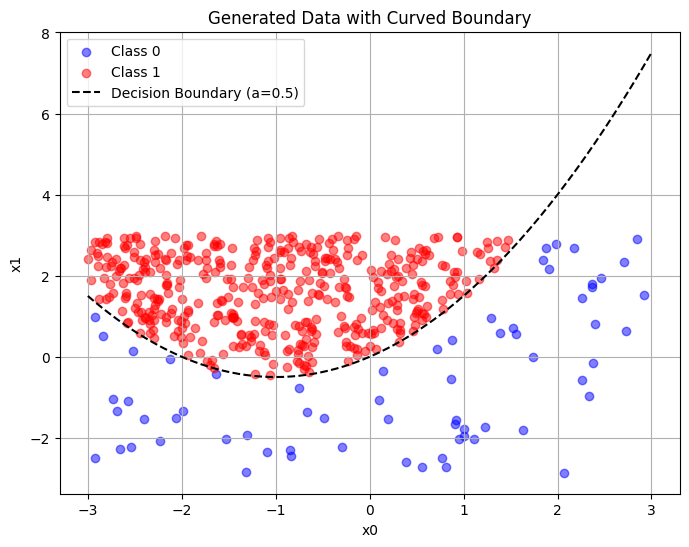

In [ ]:
X, y = generate_data(n_samples=500, a=0.5, imbalance=True)

print("Feature matrix (first 5 rows):")
print(X[:5])  # Print first 5 data points

print("\nLabels (first 20):")
print(y[:20])  # Print first 20 labels
plot_data(X, y, a=0.5)

In [ ]:
from sklearn.linear_model import LogisticRegression

def train_logistic(X_train, y_train):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    return model

In [ ]:
from sklearn.neural_network import MLPClassifier

def train_mlp(X_train, y_train, hidden_layer_sizes=(10,), max_iter=5000):
    model = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        max_iter=max_iter,
        early_stopping=True,
        validation_fraction=0.1,
        random_state=42
    )
    model.fit(X_train, y_train)
    return model

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compareModels(model1, model2, X_eval, y_eval):
    y_pred1 = model1.predict(X_eval)
    y_pred2 = model2.predict(X_eval)
    acc1 = accuracy_score(y_eval, y_pred1)
    acc2 = accuracy_score(y_eval, y_pred2)

    f1_score1 = f1_score(y_eval, y_pred1)
    f1_score2 = f1_score(y_eval, y_pred2)

    return {'accuracy': [acc1, acc2], 'f1_score': [f1_score1, f1_score2]}


In [ ]:
def run_experiment(sample_sizes=[200, 500, 1000, 2000, 5000, 10000],
                           hidden_layer_sizes=[(5,), (10,), (20,), (10,10), (20,10), (30,20,10)],
                           activations=['relu', 'tanh'],
                           a_values=[0.1, 0.5, 1, 2],
                           imbalance_options=[False, True],
                           plot_decision_boundaries=False):

    results = []

    for a in a_values:
        for imbalance in imbalance_options:
            print(f"\n=== a = {a}, imbalance = {imbalance} ===")

            n_total_samples = 20000
            X, y = generate_data(n_total_samples, a=a, imbalance=imbalance)
            X_train_full, X_eval, y_train_full, y_eval = train_test_split(X, y, test_size=0.3, random_state=42)

            print(f"Available train samples: {len(X_train_full)}, Eval samples: {len(X_eval)}")

            for n_samples in sample_sizes:
                if n_samples > len(X_train_full):
                    print(f"Skipping train size {n_samples} (not enough samples)")
                    continue

                idx = np.random.choice(len(X_train_full), size=n_samples, replace=False)
                X_train = X_train_full[idx]
                y_train = y_train_full[idx]

                print(f"\n--- Training with {n_samples} samples ---")

                # List of models to try
                model_configs = []

                # Logistic Regression
                model_configs.append({
                    'name': 'LogisticRegression',
                    'model': LogisticRegression(max_iter=5000, random_state=42),
                    'hidden_layers': None,
                    'activation': None
                })

                # MLP models
                for hl_size in hidden_layer_sizes:
                    for activation in activations:
                        model_configs.append({
                            'name': 'MLP',
                            'model': MLPClassifier(hidden_layer_sizes=hl_size, activation=activation,
                                                   max_iter=5000, validation_fraction=0.2,
                                                   early_stopping=True, random_state=40),
                            'hidden_layers': hl_size,
                            'activation': activation
                        })

                # Train all models
                for config in model_configs:
                    model = clone(config['model'])
                    model.fit(X_train, y_train)

                    y_train_pred = model.predict(X_train)
                    y_eval_pred = model.predict(X_eval)

                    # Accuracy
                    train_acc = accuracy_score(y_train, y_train_pred)
                    eval_acc = accuracy_score(y_eval, y_eval_pred)

                    # F1 score
                    train_f1 = f1_score(y_train, y_train_pred)
                    eval_f1 = f1_score(y_eval, y_eval_pred)

                    # ROC AUC score
                    # For ROC AUC, need probabilities
                    if hasattr(model, "predict_proba"):
                        y_train_proba = model.predict_proba(X_train)[:, 1]
                        y_eval_proba = model.predict_proba(X_eval)[:, 1]
                        train_auc = roc_auc_score(y_train, y_train_proba)
                        eval_auc = roc_auc_score(y_eval, y_eval_proba)
                    else:
                        # fallback if predict_proba not available
                        train_auc = np.nan
                        eval_auc = np.nan

                    # Count parameters
                    if config['name'] == 'LogisticRegression':
                        total_params = model.coef_.size + model.intercept_.size
                    elif config['name'] == 'MLP':
                        total_params = sum(coef.size for coef in model.coefs_) + sum(intercept.size for intercept in model.intercepts_)
                    else:
                        total_params = None

                    print(f"{config['name']} - Layers: {config['hidden_layers']} Activation: {config['activation']}")
                    print(f"Train Acc: {train_acc:.4f}, Eval Acc: {eval_acc:.4f}")

                    results.append({
                        'model': config['name'],
                        'train_size': n_samples,
                        'hidden_layers': config['hidden_layers'],
                        'activation': config['activation'],
                        'params': total_params,
                        'train_accuracy': train_acc,
                        'eval_accuracy': eval_acc,
                        'train_f1': train_f1,
                        'eval_f1': eval_f1,
                        'train_auc': train_auc,
                        'eval_auc': eval_auc,
                        'a': a,
                        'imbalance': imbalance
                    })

                    if plot_decision_boundaries:
                        plot_decision_boundary(model, X_eval, y_eval,
                            title=f"{config['name']} {config['hidden_layers']} {config['activation']} a={a} n={n_samples}")

    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    return results_df


In [ ]:
def plot_data(X, y, title="Data"):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', s=10, alpha=0.6)
    plt.title(title)
    plt.xlabel("x0")
    plt.ylabel("x1")
    plt.grid(True)
    plt.show()

In [ ]:
from matplotlib.colors import ListedColormap  # Allows us to define custom colors for plotting

def plot_decision_boundary(X, y, model, title="Decision Boundary"):

    h = 0.02  # Step size for the mesh grid (smaller = smoother boundary)

    # Set the limits of the grid slightly beyond the min/max of the data
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Create a mesh grid over the 2D space
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predict class for every point on the grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])  # Flatten the grid and stack x0 and x1
    Z = Z.reshape(xx.shape)  # Reshape to match the grid shape for contour plotting

    # Set up the plot
    plt.figure(figsize=(6, 6))  # Square figure

    # Light colors for the background (decision regions)
    cmap_light = ListedColormap(["#FFAAAA", "#AAAAFF"])  # Light red for class 0, light blue for class 1

    # Bold colors for the actual data points
    cmap_bold = ListedColormap(["#FF0000", "#0000FF"])  # Red for class 0, blue for class 1

    # Plot decision boundary using filled contours
    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.6)

    # Scatter plot of the original data points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=10, edgecolor='k')  # Small dots with black edges

    # Labels and aesthetics
    plt.title(title)
    plt.xlabel("x0")
    plt.ylabel("x1")
    plt.grid(True)
    plt.show()

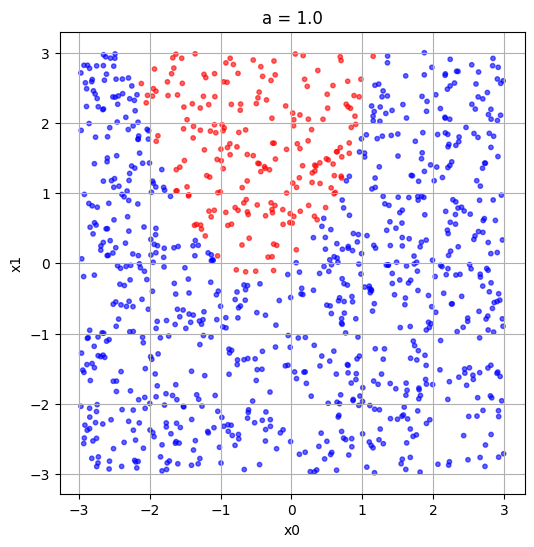

In [ ]:
X, y = generate_data(n_samples=1000, a=1.0)  # Generate synthetic data with a curved boundary
plot_data(X, y, title="a = 1.0")  # Plot the data (assuming plot_data just shows the scatter)


In [ ]:
# Run your experiment
results_df = run_experiment()


=== a = 0.1, imbalance = False ===
Available train samples: 14000, Eval samples: 6000

--- Training with 200 samples ---
LogisticRegression - Layers: None Activation: None
Train Acc: 0.9900, Eval Acc: 0.9648
MLP - Layers: (5,) Activation: relu
Train Acc: 0.7100, Eval Acc: 0.6462
MLP - Layers: (5,) Activation: tanh
Train Acc: 0.6650, Eval Acc: 0.6548
MLP - Layers: (10,) Activation: relu
Train Acc: 0.4700, Eval Acc: 0.5435
MLP - Layers: (10,) Activation: tanh
Train Acc: 0.4700, Eval Acc: 0.5435
MLP - Layers: (20,) Activation: relu
Train Acc: 0.5100, Eval Acc: 0.5352
MLP - Layers: (20,) Activation: tanh
Train Acc: 0.7650, Eval Acc: 0.7542
MLP - Layers: (10, 10) Activation: relu
Train Acc: 0.4700, Eval Acc: 0.4758
MLP - Layers: (10, 10) Activation: tanh
Train Acc: 0.7350, Eval Acc: 0.6922
MLP - Layers: (20, 10) Activation: relu
Train Acc: 0.9050, Eval Acc: 0.8985
MLP - Layers: (20, 10) Activation: tanh
Train Acc: 0.8400, Eval Acc: 0.7913
MLP - Layers: (30, 20, 10) Activation: relu
Train A

In [ ]:
results_df.head()

model  train_size hidden_layers activation  params  \
0  LogisticRegression         200          None       None       3   
1                 MLP         200          (5,)       relu      21   
2                 MLP         200          (5,)       tanh      21   
3                 MLP         200         (10,)       relu      41   
4                 MLP         200         (10,)       tanh      41   

   train_accuracy  eval_accuracy  train_f1   eval_f1  train_auc  eval_auc  \
0           0.990       0.964833  0.990476  0.961671   1.000000  0.996630   
1           0.710       0.759333  0.623377  0.656518   0.923926  0.914269   
2           0.580       0.570833  0.693431  0.666061   0.812324  0.789106   
3           0.525       0.530167  0.463277  0.444969   0.552188  0.548213   
4           0.390       0.435500  0.413462  0.417340   0.373344  0.399987   

     a  imbalance  
0  0.1      False  
1  0.1      False  
2  0.1      False  
3  0.1      False  
4  0.1      False

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_final_results(results_df):
    sns.set(style="whitegrid", font_scale=1.0)  # Reduced font scale here

    for a in results_df['a'].unique():
        for imbalance in results_df['imbalance'].unique():
            print(f"\n=== a = {a}, imbalance = {imbalance} ===")
            # 1. Logistic Regression: Train Size vs Accuracy
            logreg_df = results_df[(results_df['model'] == 'LogisticRegression') & (results_df['a'] == a) & (results_df['imbalance'] == imbalance)]

            plt.figure(figsize=(7, 4))
            plt.plot(logreg_df['train_size'], logreg_df['train_accuracy'], marker='o', label='Train Accuracy')
            plt.plot(logreg_df['train_size'], logreg_df['eval_accuracy'], marker='s', label='Eval Accuracy')
            plt.title('Logistic Regression: Accuracy vs Train Size', fontsize=12)
            plt.xlabel('Train Set Size', fontsize=10)
            plt.ylabel('Accuracy', fontsize=10)
            plt.legend(fontsize=9)
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            for hl_size in results_df['hidden_layers'].unique():
                if hl_size is None:
                    continue
                # 2. MLP: Train Size vs Accuracy
                mlp_df = results_df[
                    (results_df['model'] == 'MLP') & (results_df['a'] == a) & (results_df['imbalance'] == imbalance) &
                    (results_df['hidden_layers'] == hl_size) & (results_df['activation'] == 'relu')
                ]

                plt.figure(figsize=(7, 4))
                plt.plot(logreg_df['train_size'], logreg_df['train_accuracy'], marker='o', label='Logistic Regression Train Accuracy')
                plt.plot(logreg_df['train_size'], logreg_df['eval_accuracy'], marker='s', label='Logistic Regression Eval Accuracy')
                plt.plot(mlp_df['train_size'], mlp_df['train_accuracy'], marker='o', label='MLP Train Accuracy')
                plt.plot(mlp_df['train_size'], mlp_df['eval_accuracy'], marker='s', label='MLP Eval Accuracy')
                plt.title(f'Accuracy vs Train Size\n(MLP Hidden layers={hl_size}, imbalance={imbalance}, a={a})', fontsize=12)
                plt.xlabel('Train Set Size', fontsize=10)
                plt.ylabel('Accuracy', fontsize=10)
                plt.legend(fontsize=9)
                plt.grid(True)
                plt.tight_layout()
                plt.show()

                # 3. MLP: Train Size vs F1 Score
                plt.figure(figsize=(7, 4))
                plt.plot(logreg_df['train_size'], logreg_df['train_f1'], marker='o', label='Logistic Regression Train F1')
                plt.plot(logreg_df['train_size'], logreg_df['eval_f1'], marker='s', label='Logistic Regression Eval F1')
                plt.plot(mlp_df['train_size'], mlp_df['train_f1'], marker='o', label='MLP Train F1')
                plt.plot(mlp_df['train_size'], mlp_df['eval_f1'], marker='s', label='MLP Eval F1')
                plt.title(f'F1 Score vs Train Size\n(MLP Hidden layers={hl_size}, imbalance={imbalance}, a={a})', fontsize=12)
                plt.xlabel('Train Set Size', fontsize=10)
                plt.ylabel('F1 Score', fontsize=10)
                plt.legend(fontsize=9)
                plt.grid(True)
                plt.tight_layout()
                plt.show()

            # 4. MLP: Number of Parameters vs Accuracy (only when train_size=10000)
            mlp_df = results_df[
                (results_df['model'] == 'MLP') & (results_df['a'] == a) & (results_df['imbalance'] == imbalance) &
                (results_df['activation'] == 'relu') & (results_df['train_size'] == 10000)
            ]

            plt.figure(figsize=(7, 4))
            plt.plot(mlp_df['params'], mlp_df['train_accuracy'], marker='o', label='Train Accuracy')
            plt.plot(mlp_df['params'], mlp_df['eval_accuracy'], marker='s', label='Eval Accuracy')
            plt.title(f'MLP: Accuracy vs Number of Parameters\n(imbalance={imbalance}, a={a})', fontsize=12)
            plt.xlabel('Number of Parameters', fontsize=10)
            plt.ylabel('Accuracy', fontsize=10)
            plt.legend(fontsize=9)
            plt.grid(True)
            plt.tight_layout()
            plt.show()



=== a = 0.1, imbalance = False ===


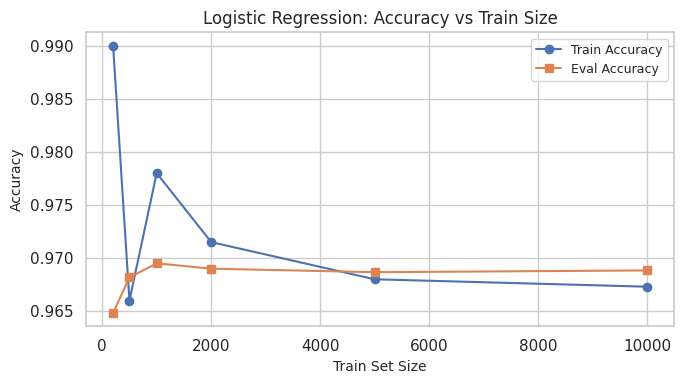

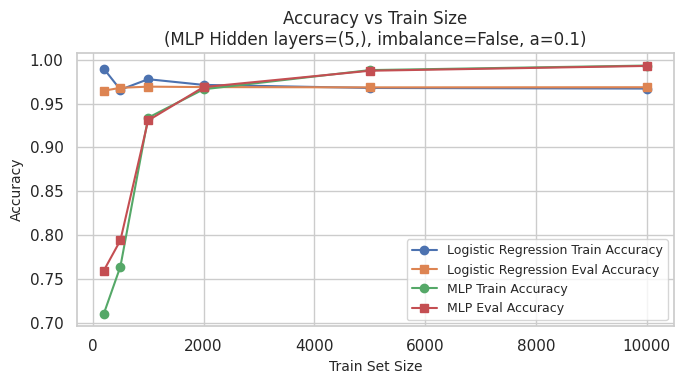

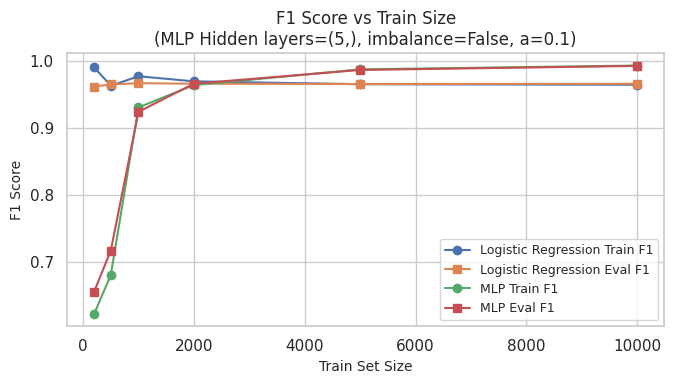

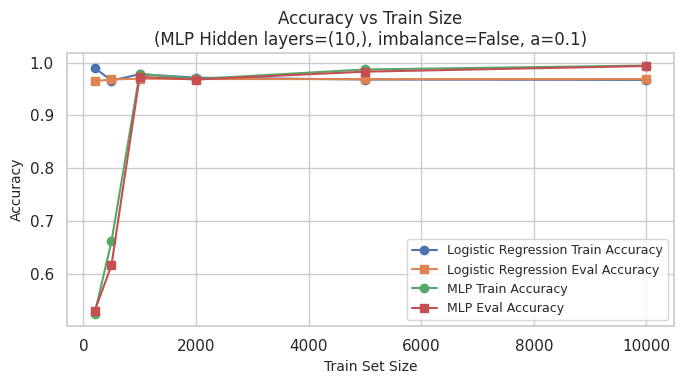

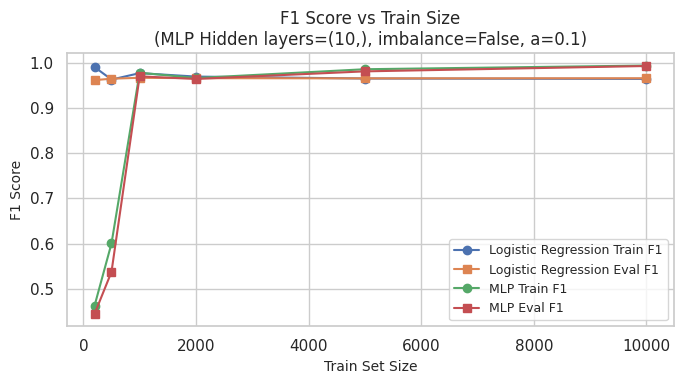

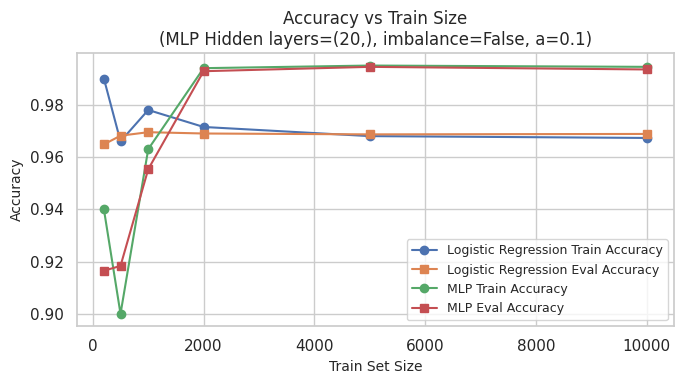

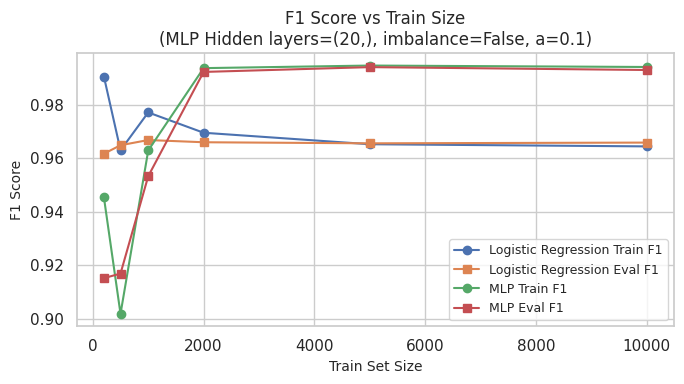

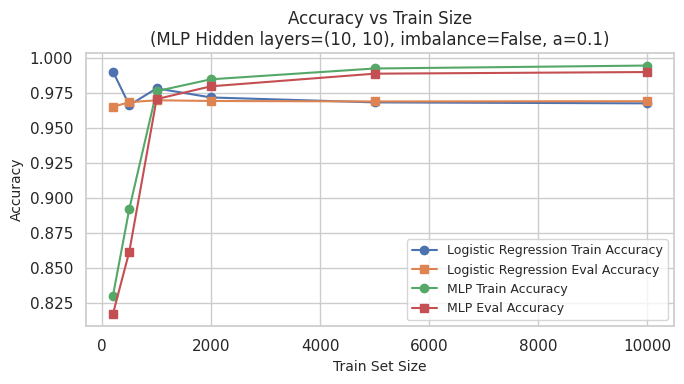

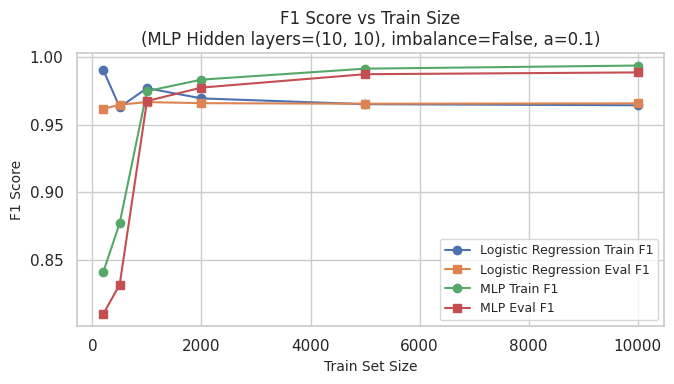

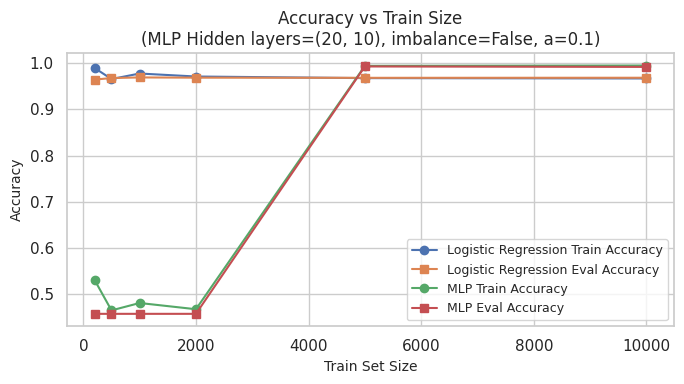

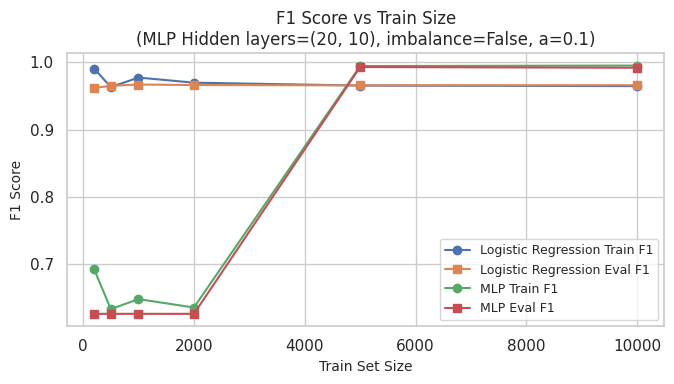

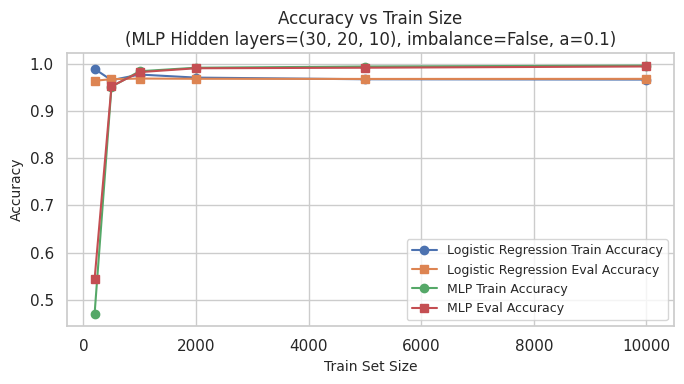

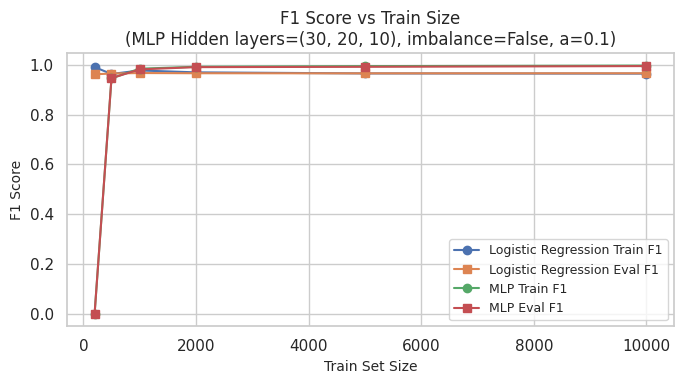

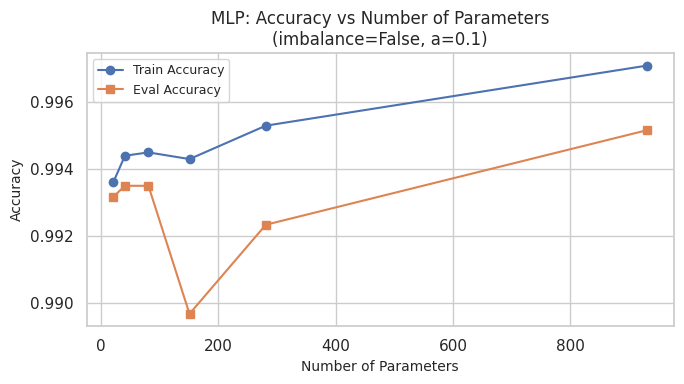


=== a = 0.1, imbalance = True ===


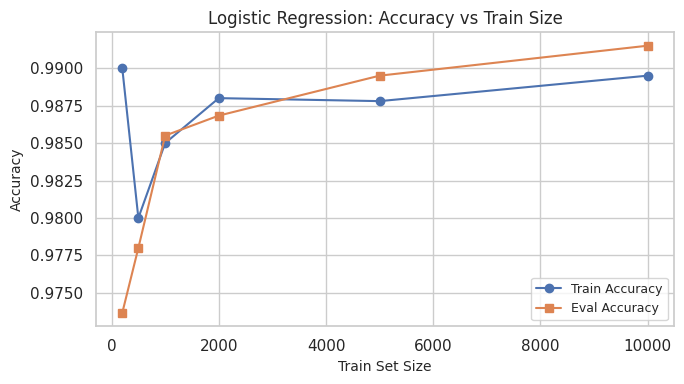

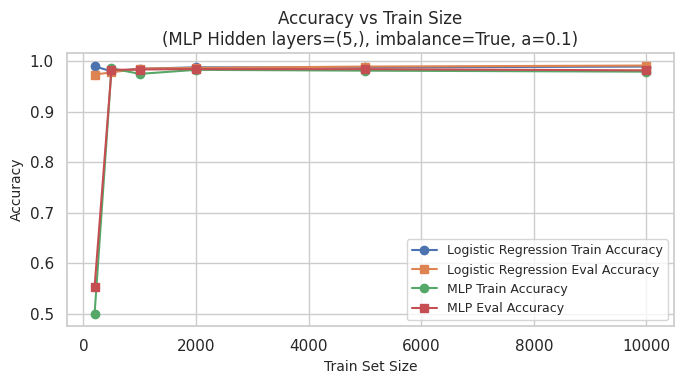

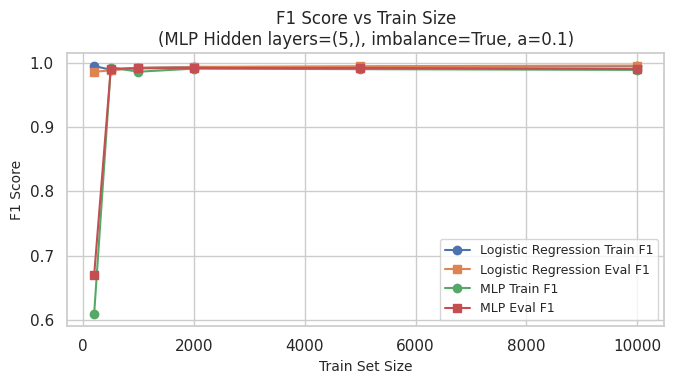

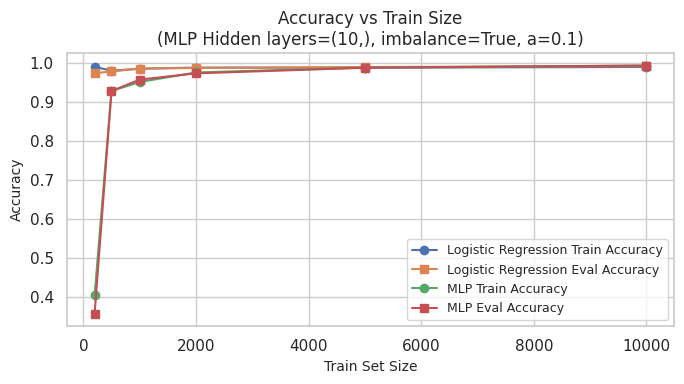

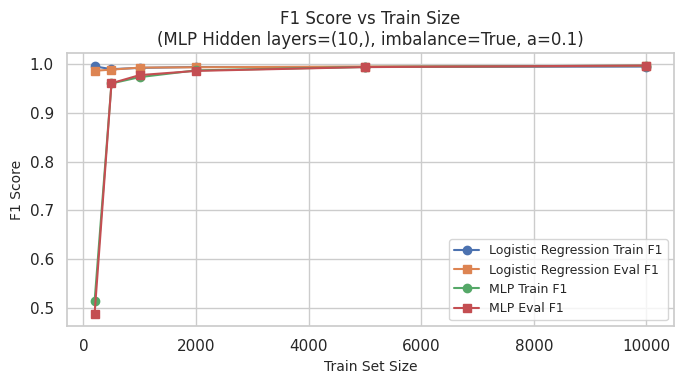

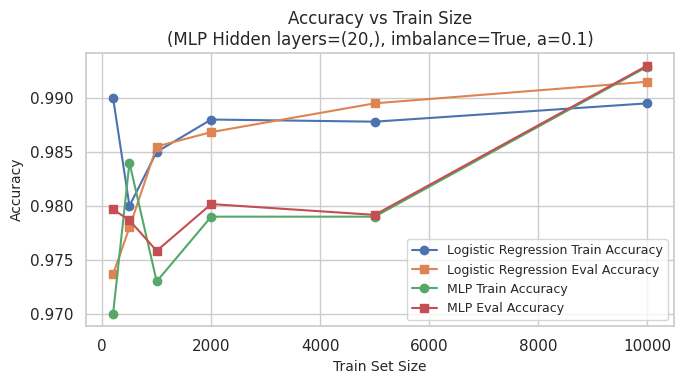

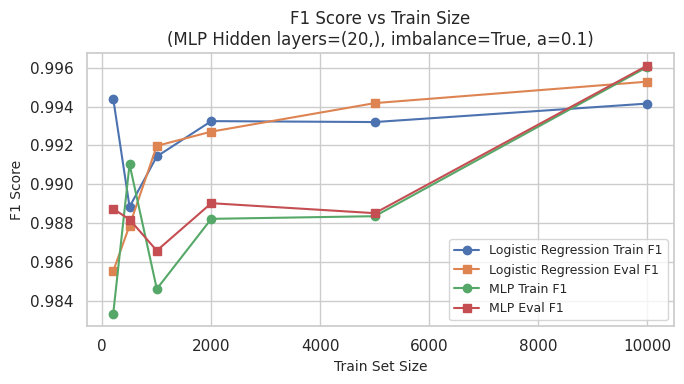

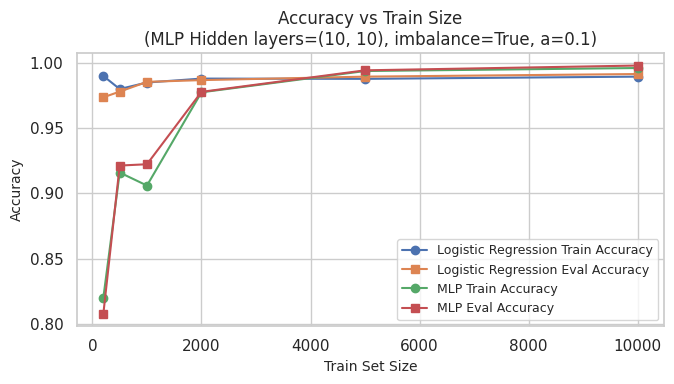

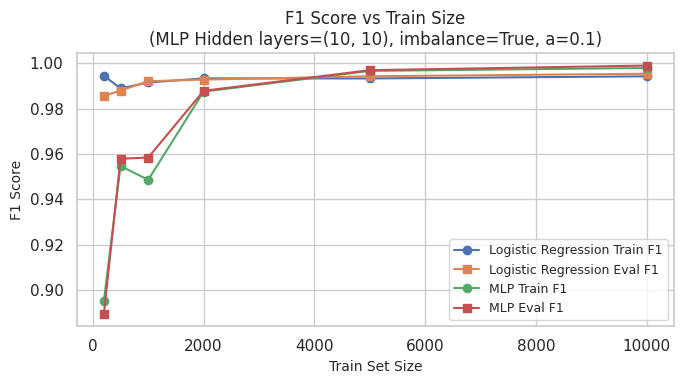

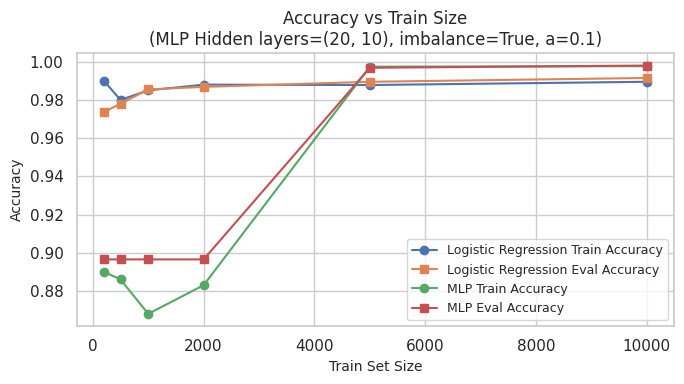

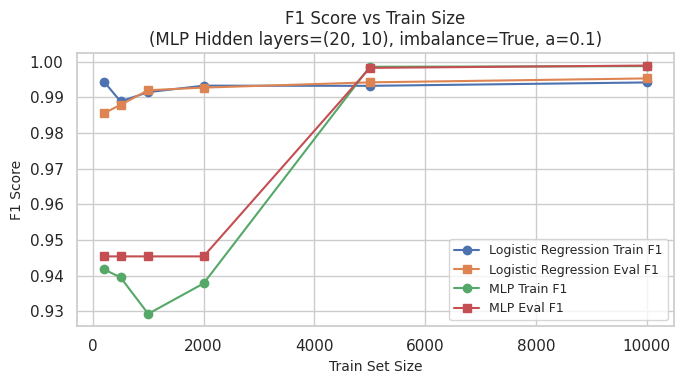

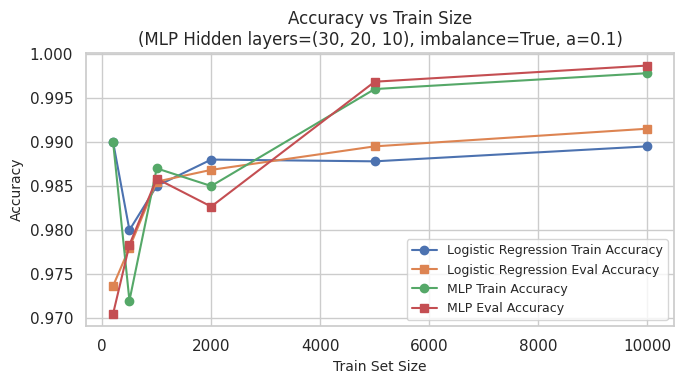

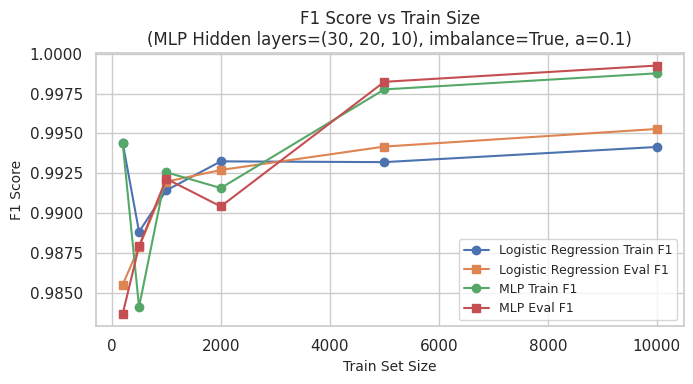

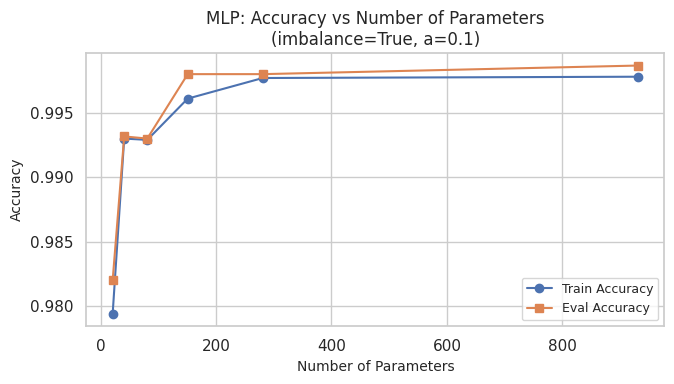


=== a = 0.5, imbalance = False ===


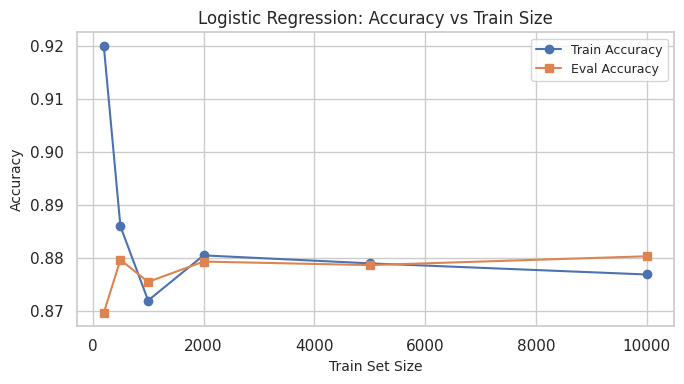

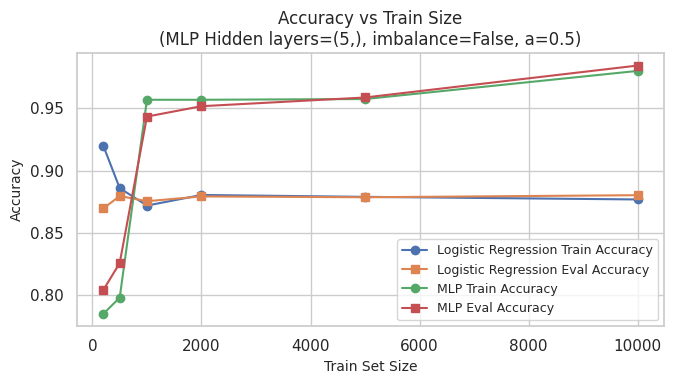

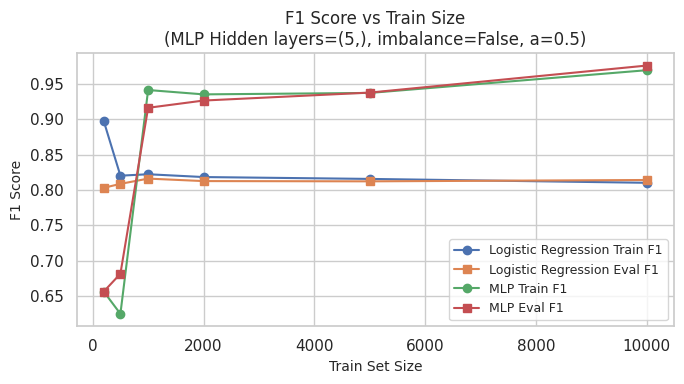

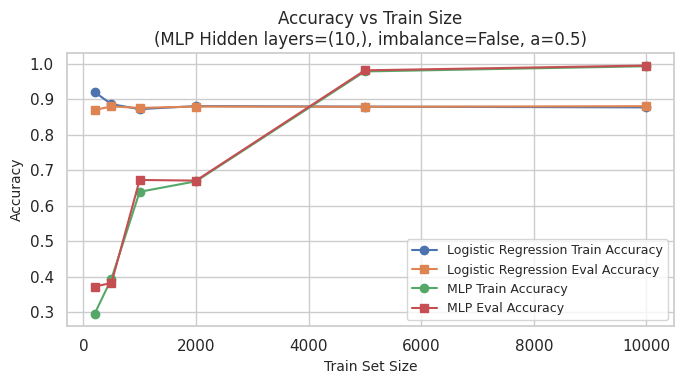

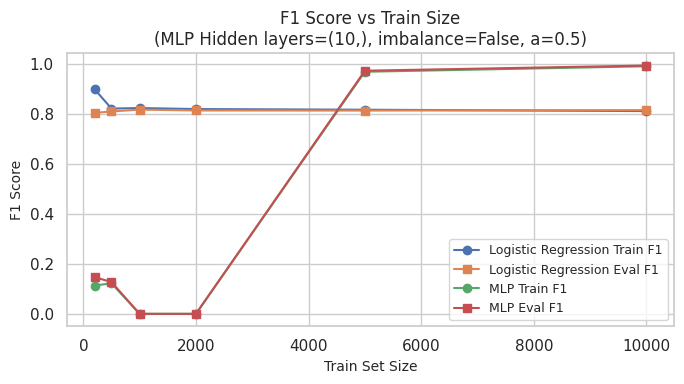

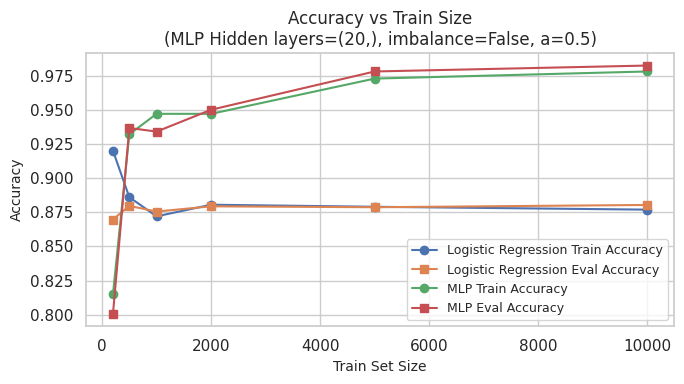

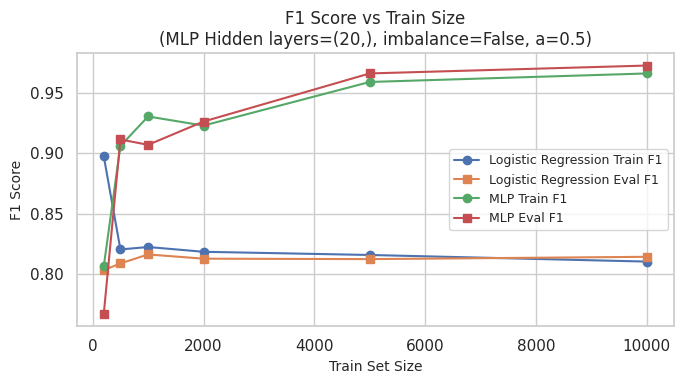

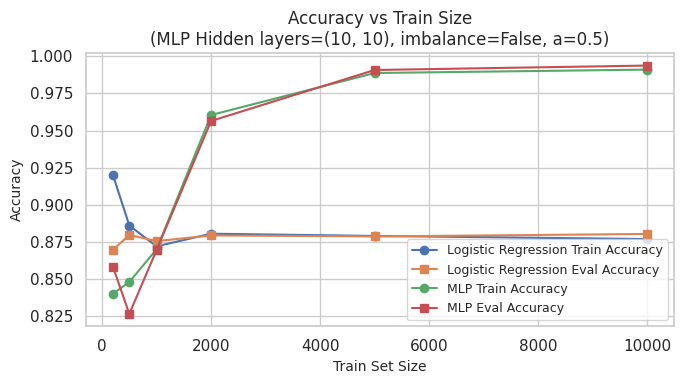

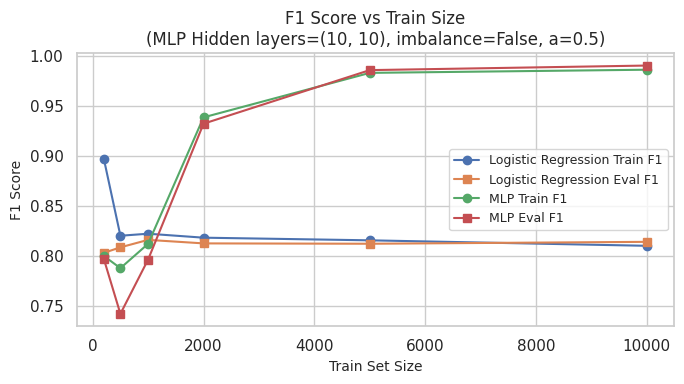

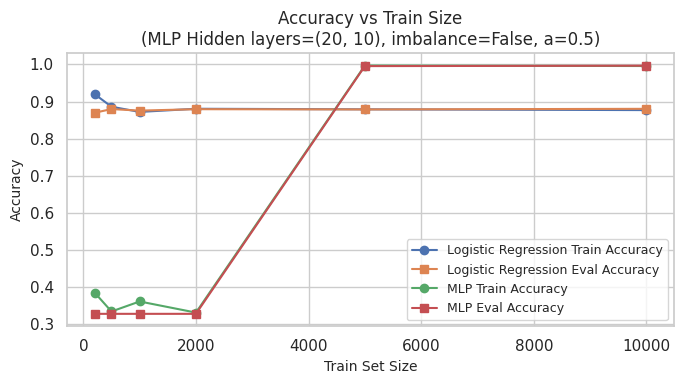

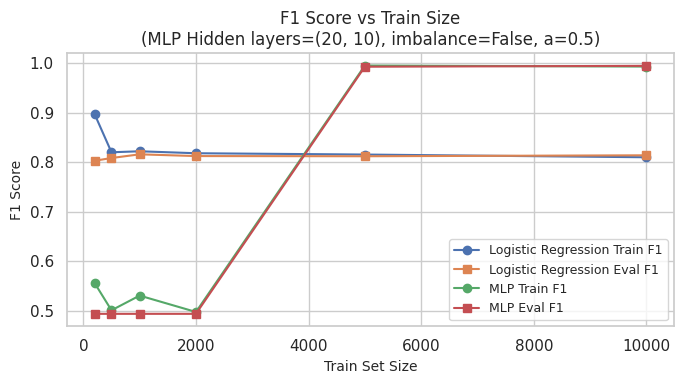

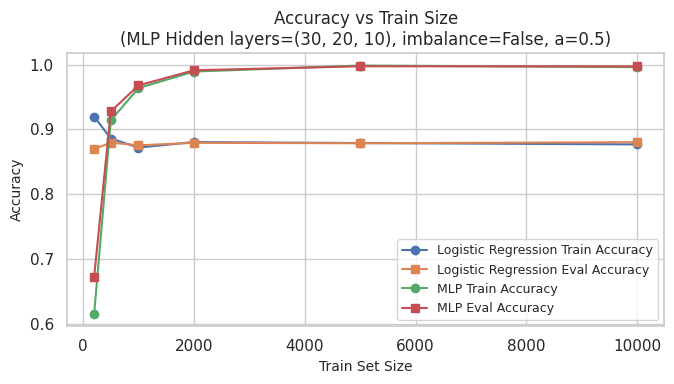

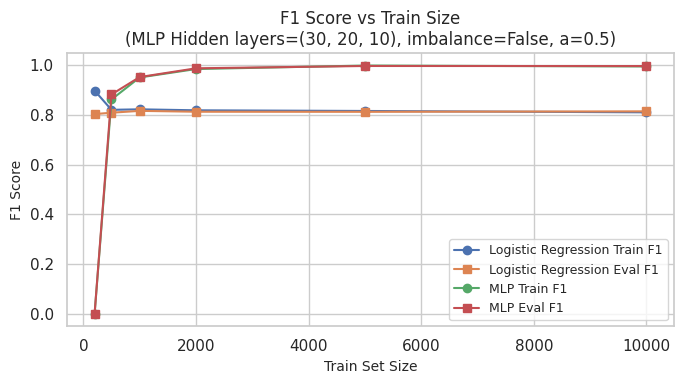

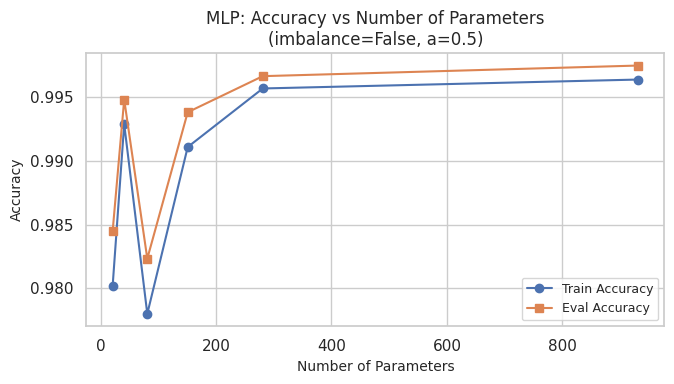


=== a = 0.5, imbalance = True ===


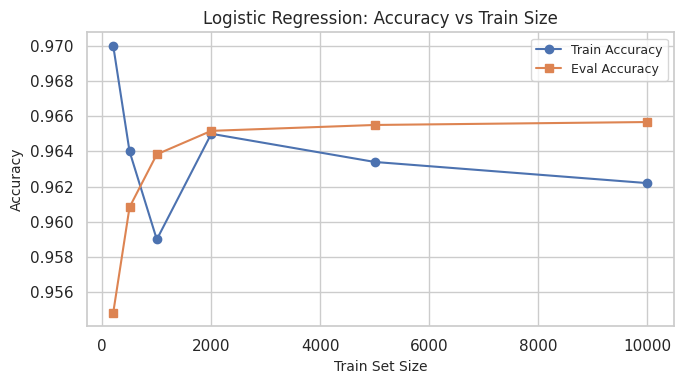

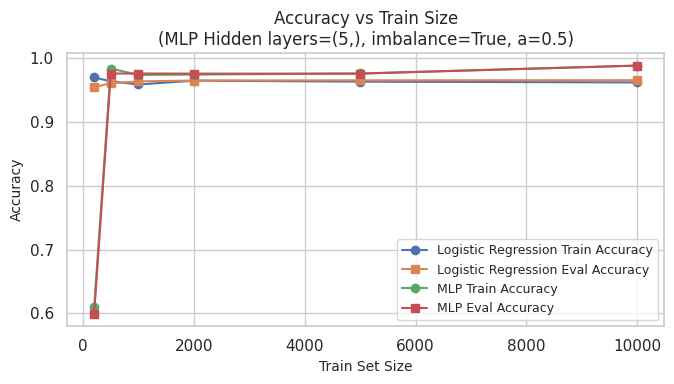

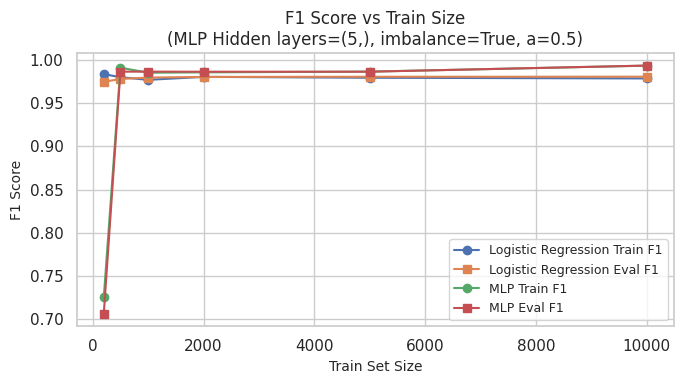

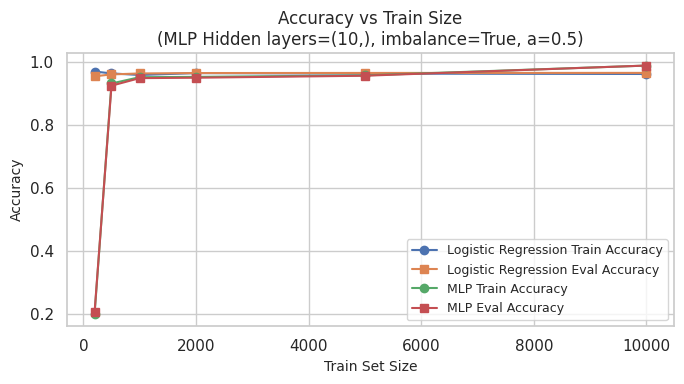

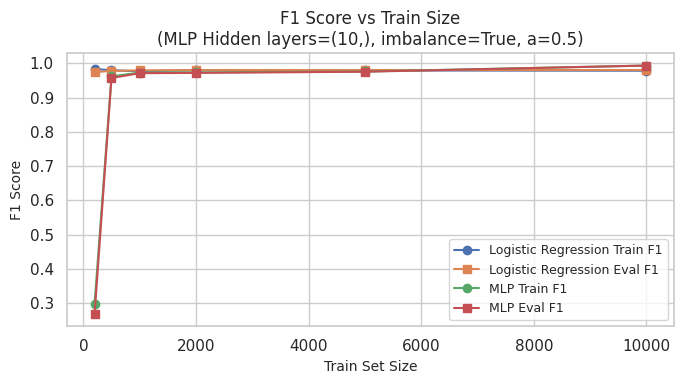

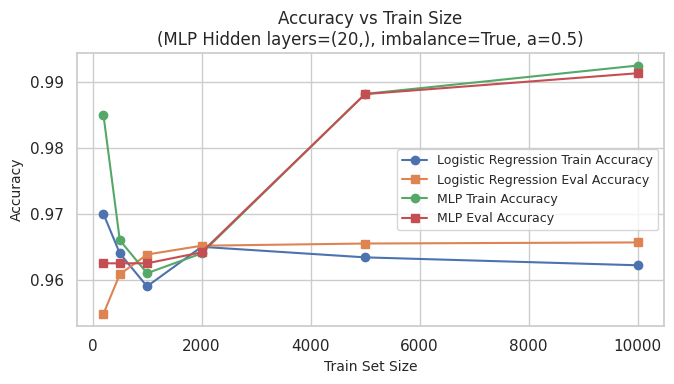

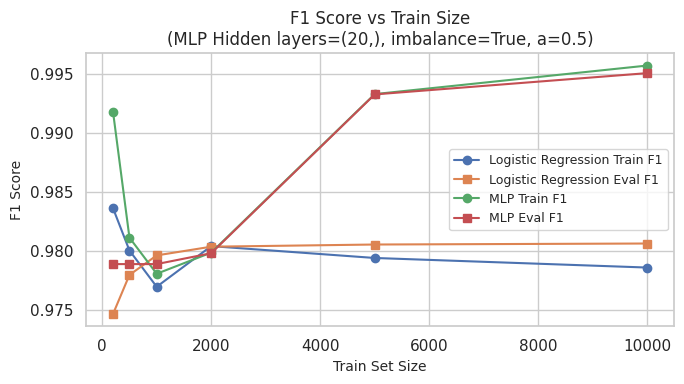

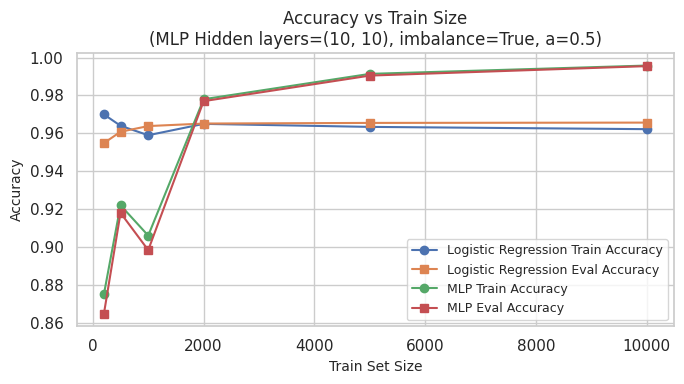

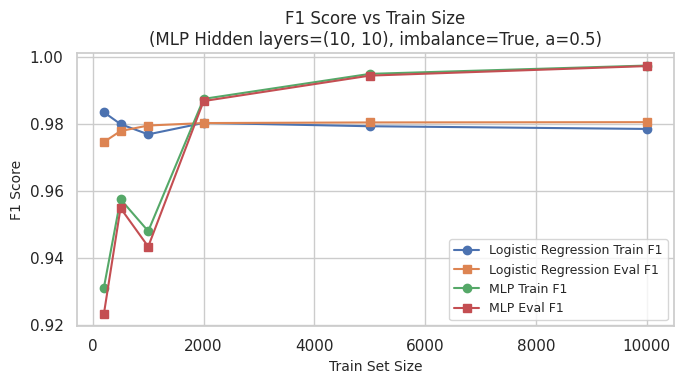

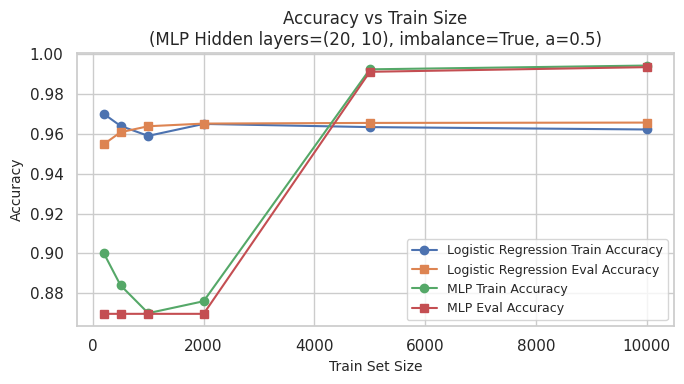

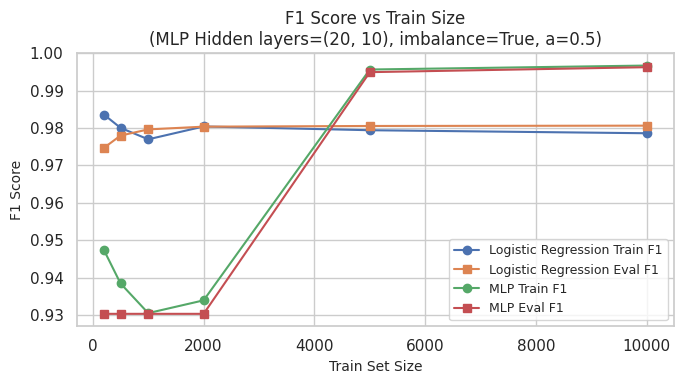

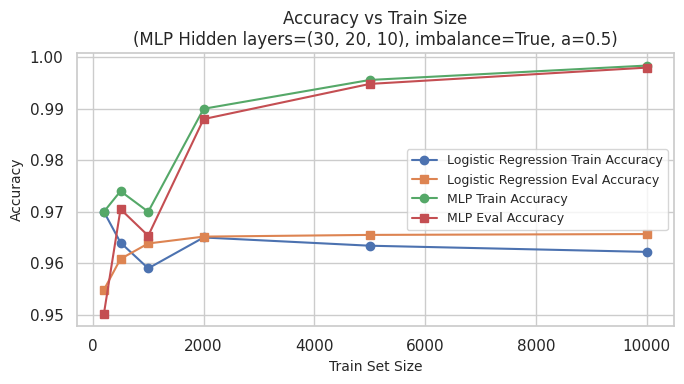

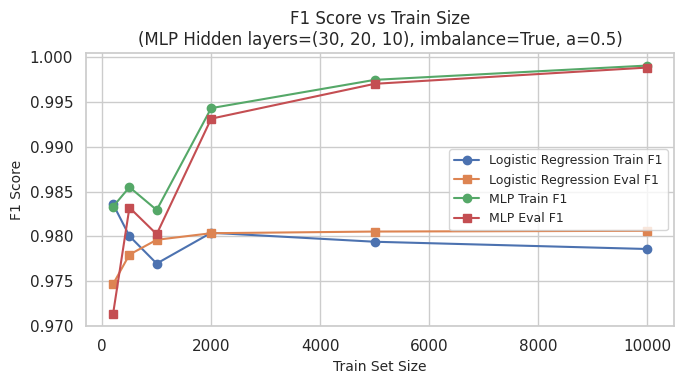

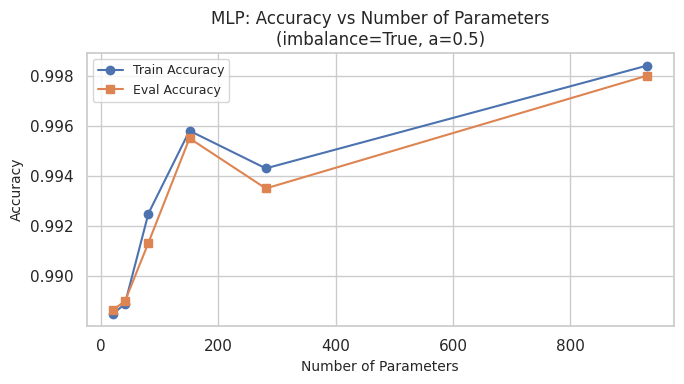


=== a = 1.0, imbalance = False ===


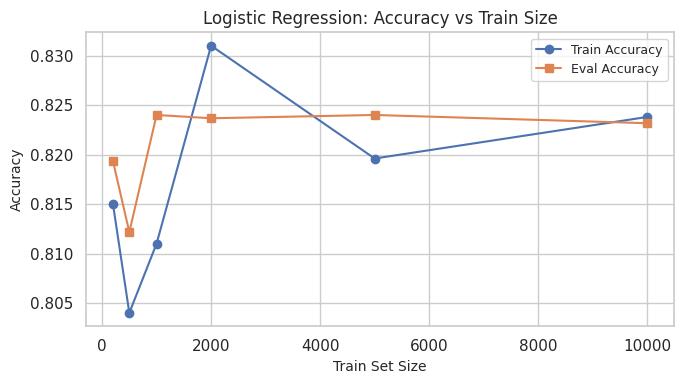

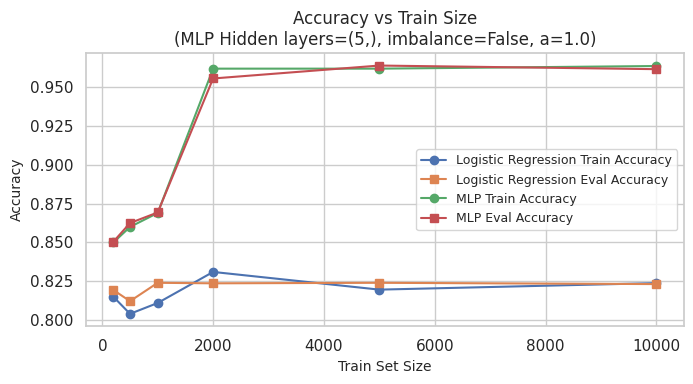

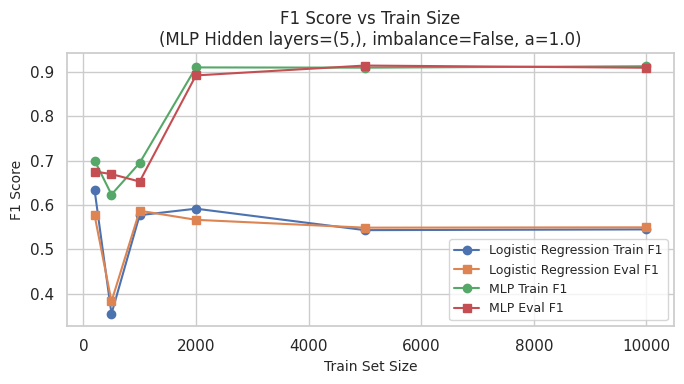

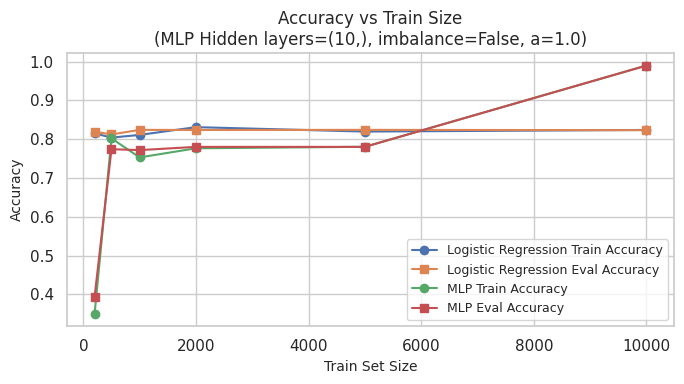

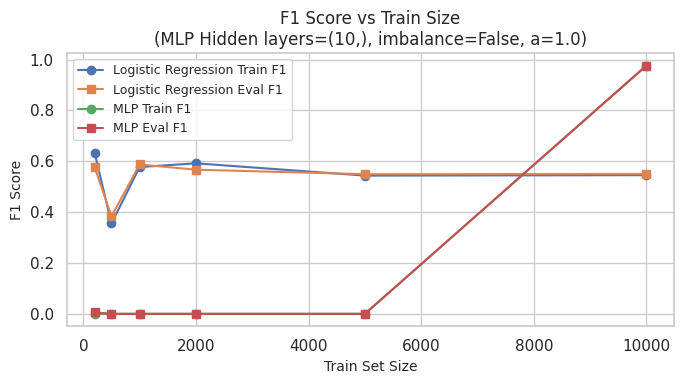

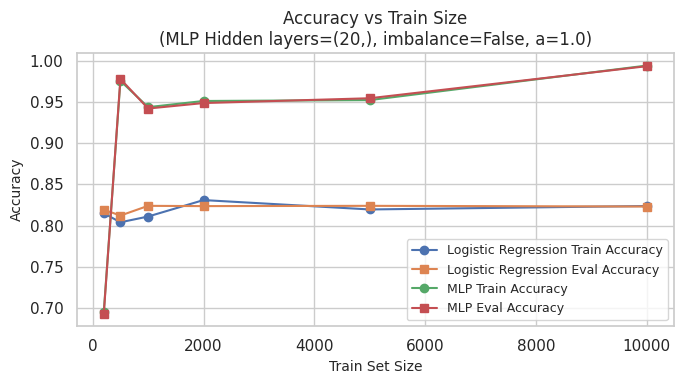

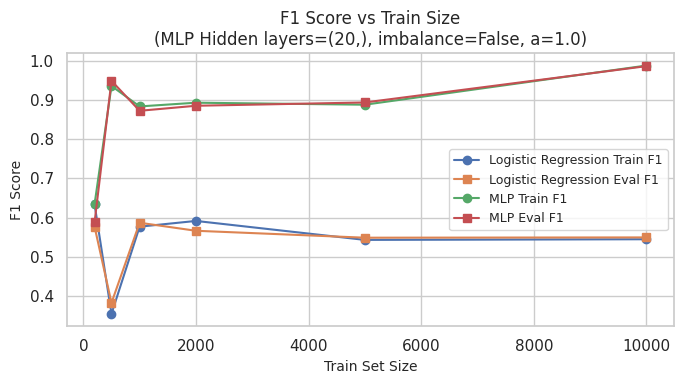

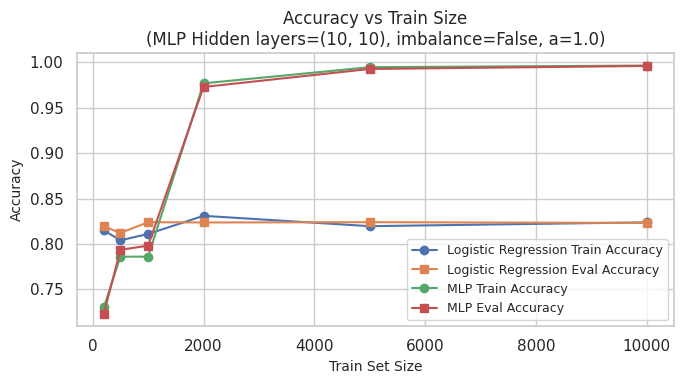

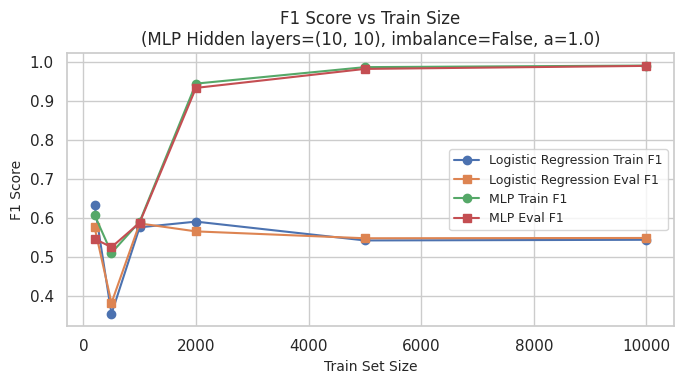

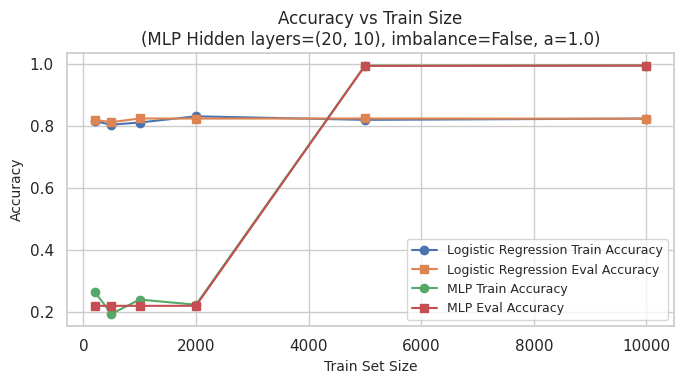

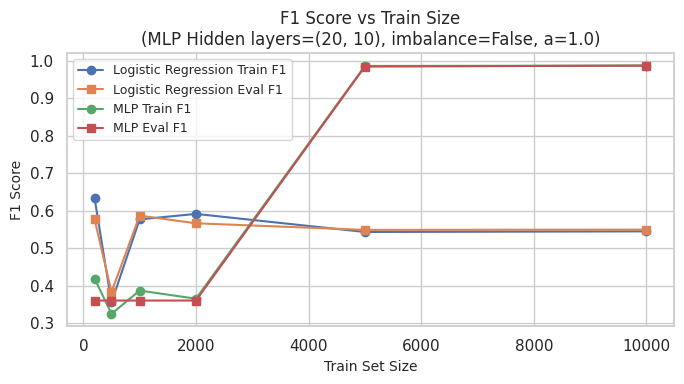

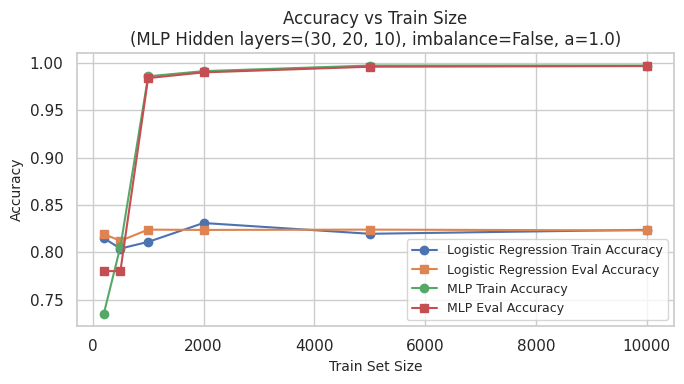

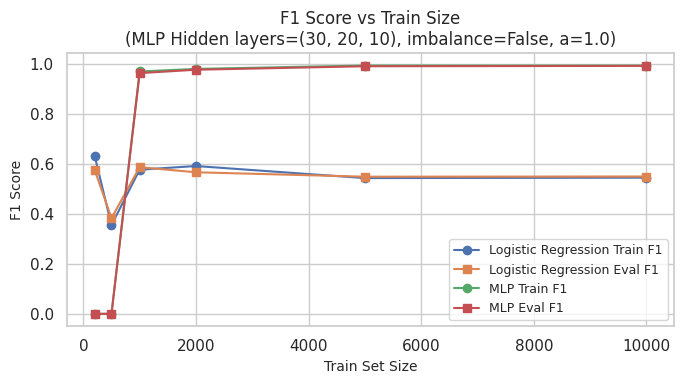

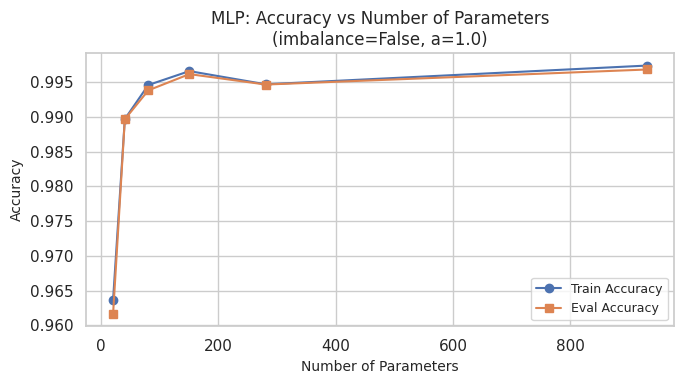


=== a = 1.0, imbalance = True ===


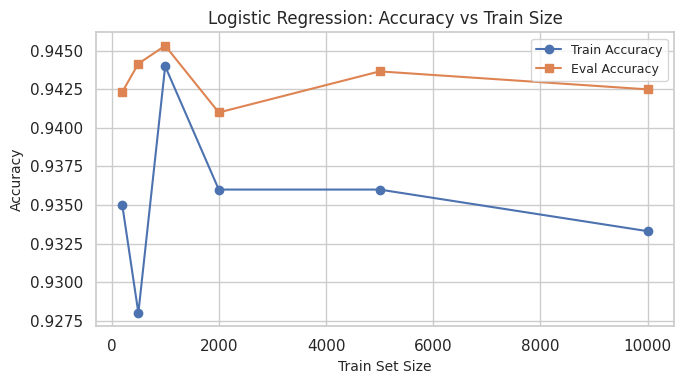

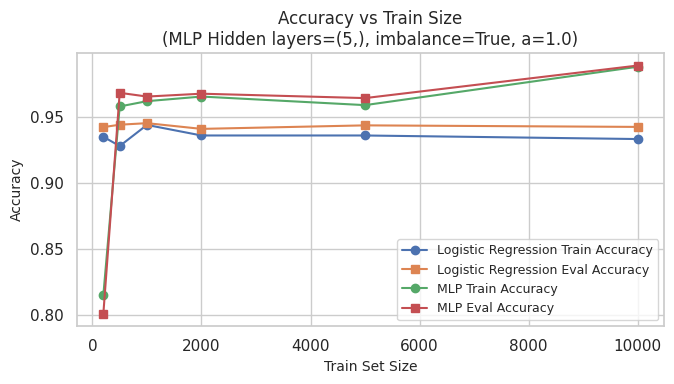

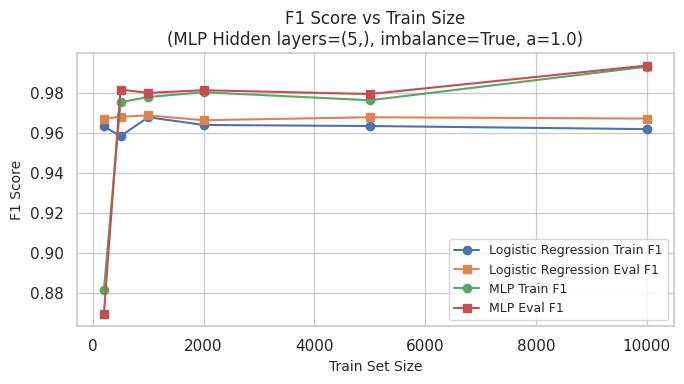

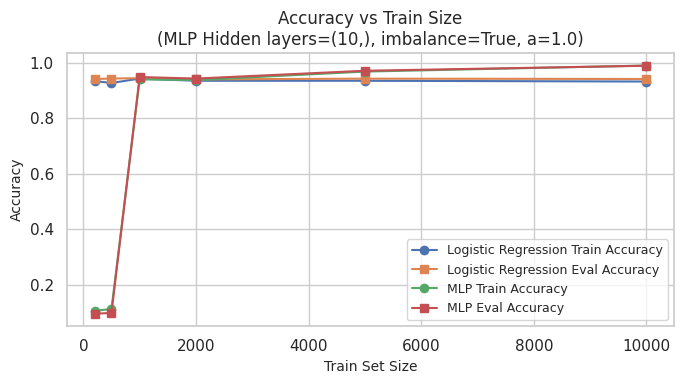

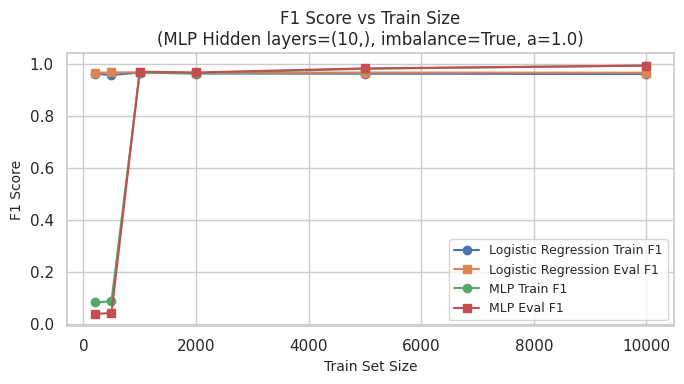

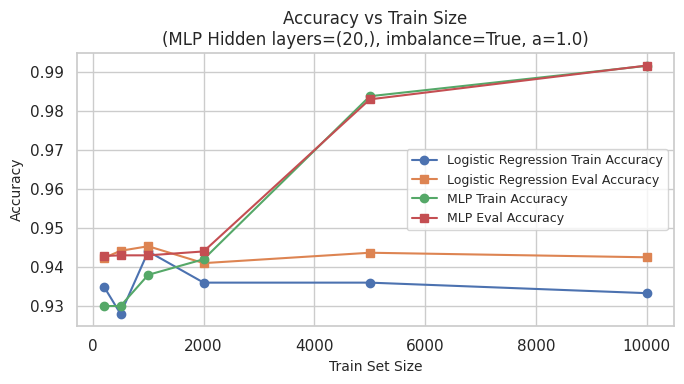

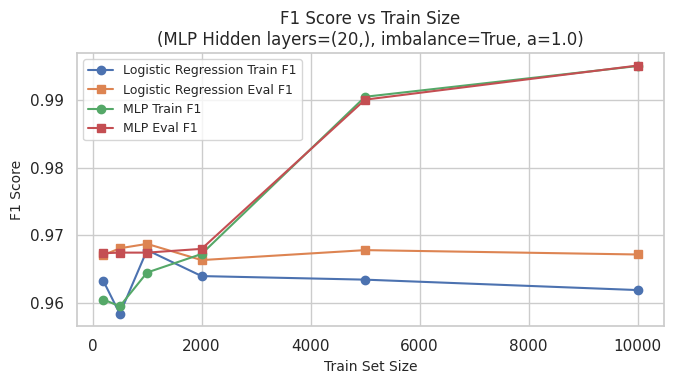

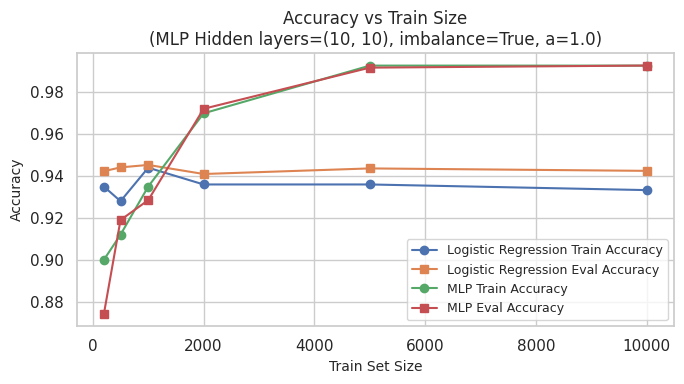

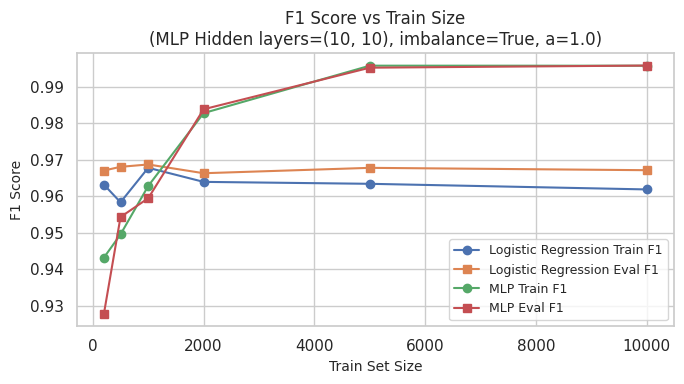

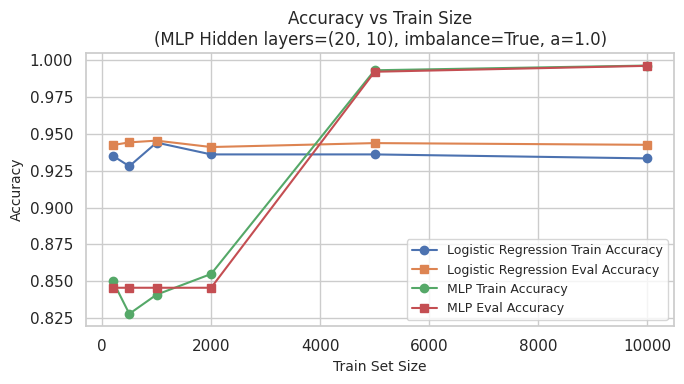

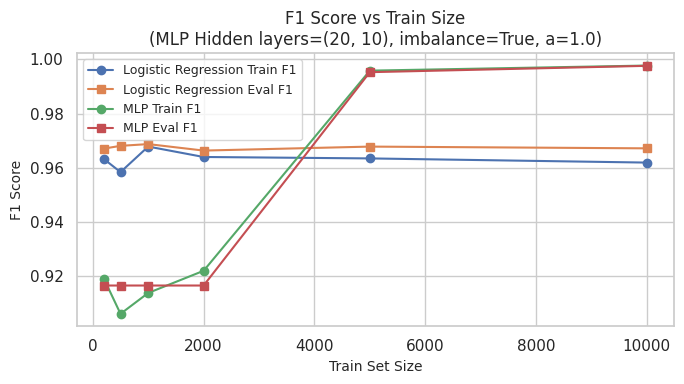

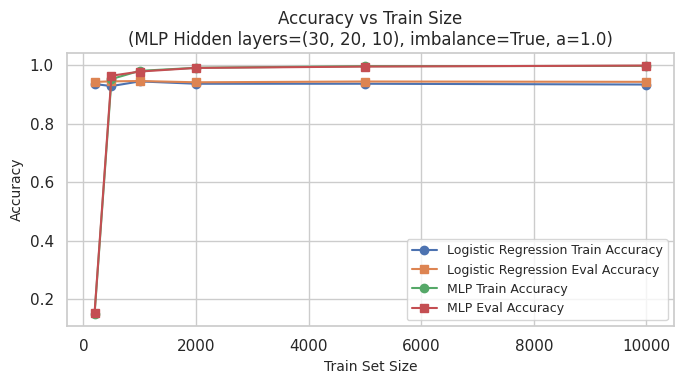

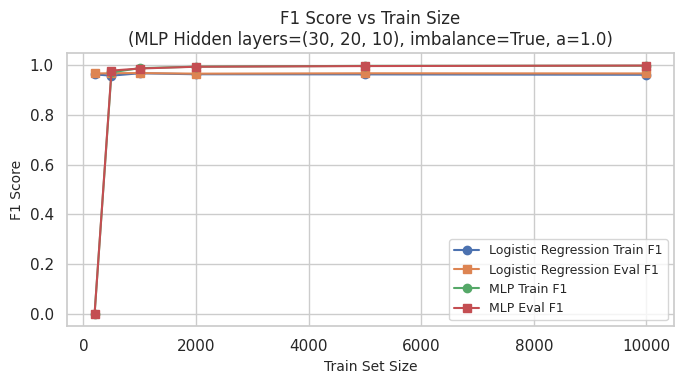

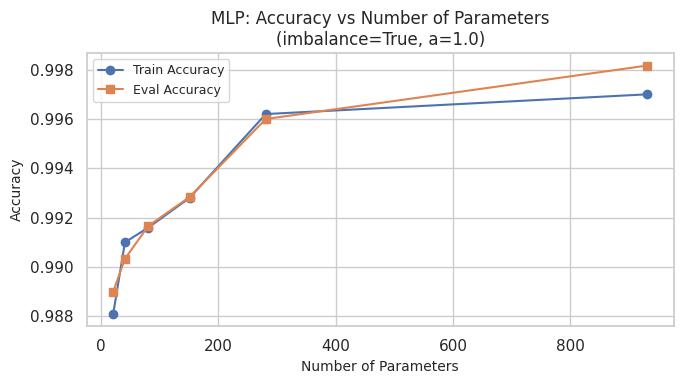


=== a = 2.0, imbalance = False ===


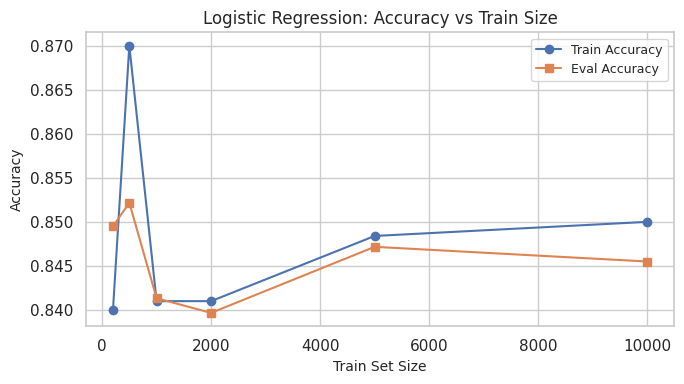

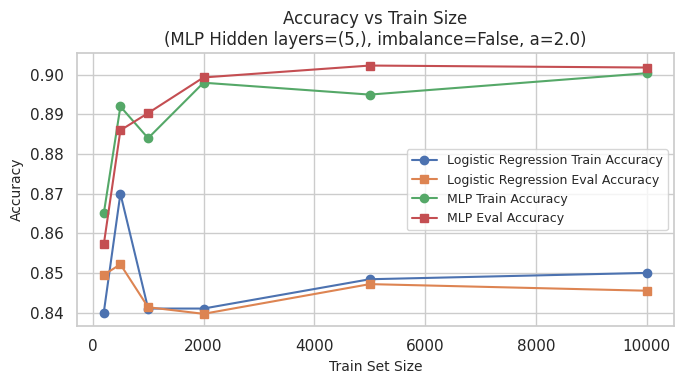

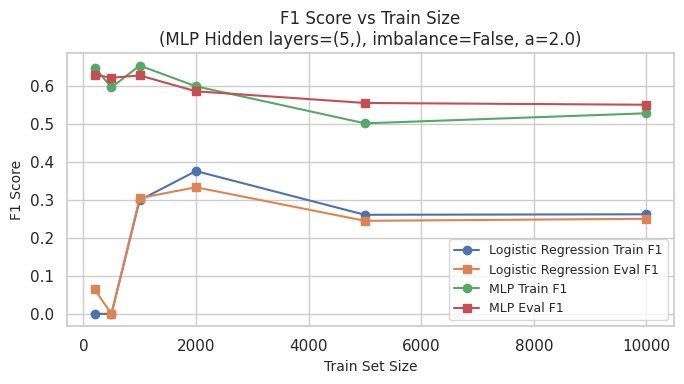

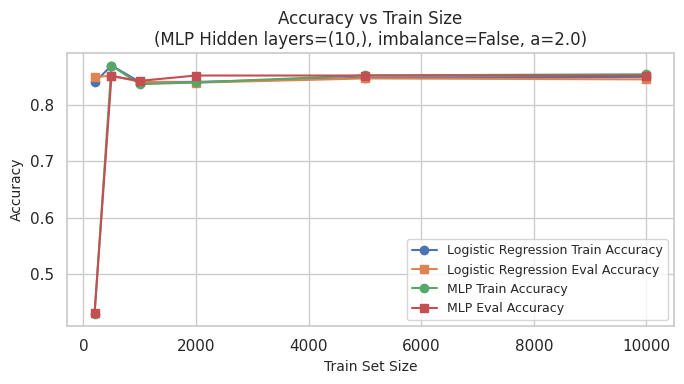

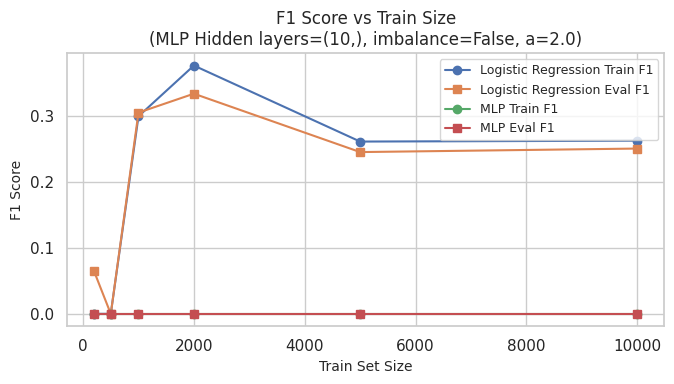

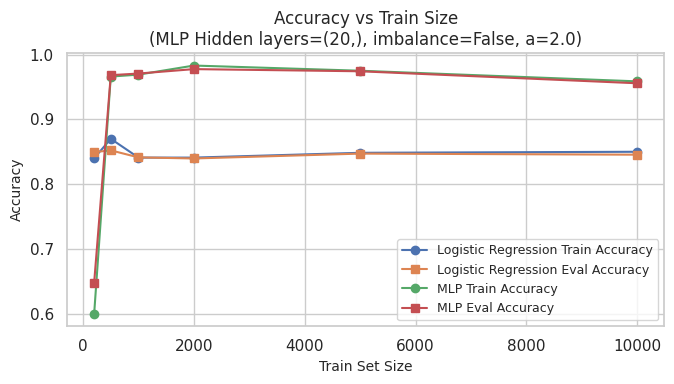

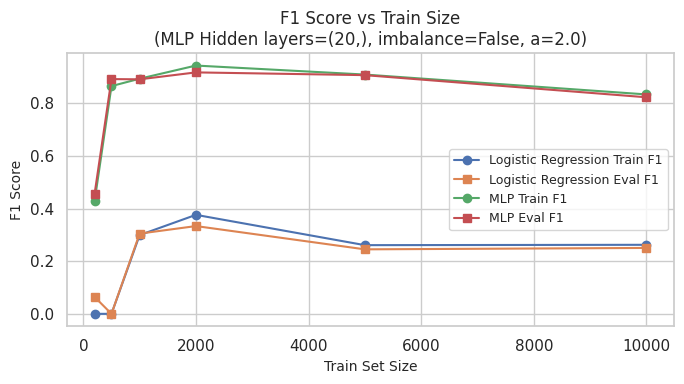

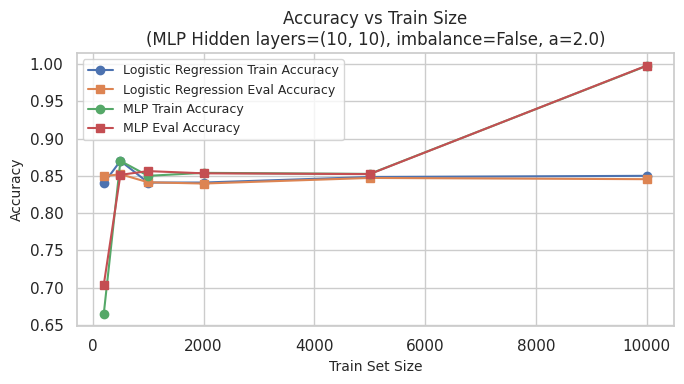

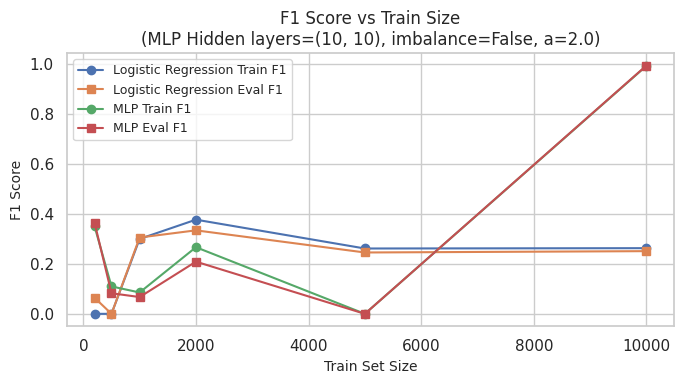

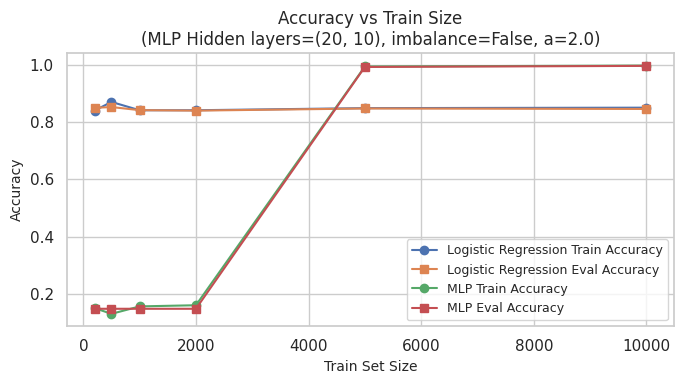

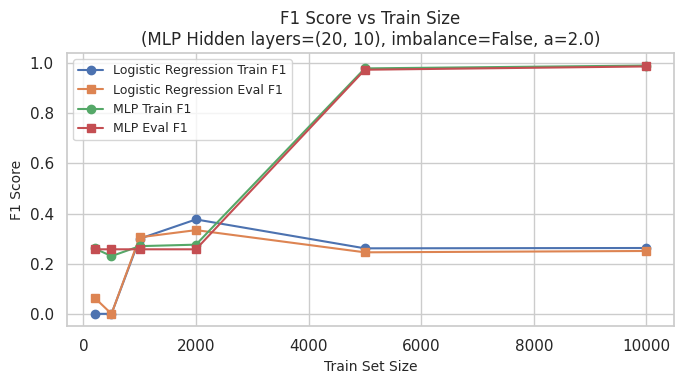

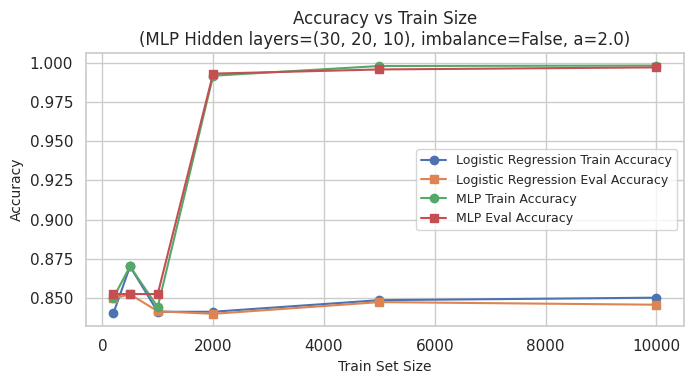

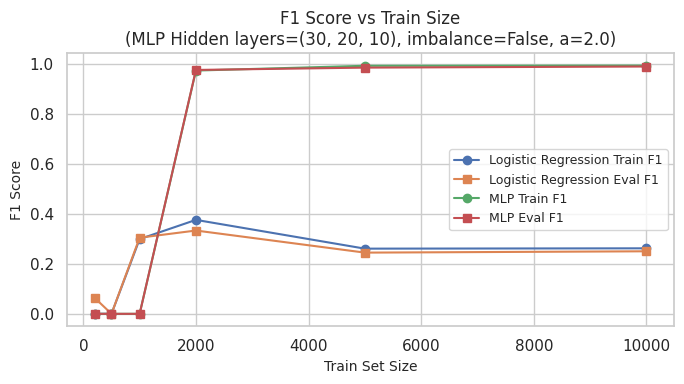

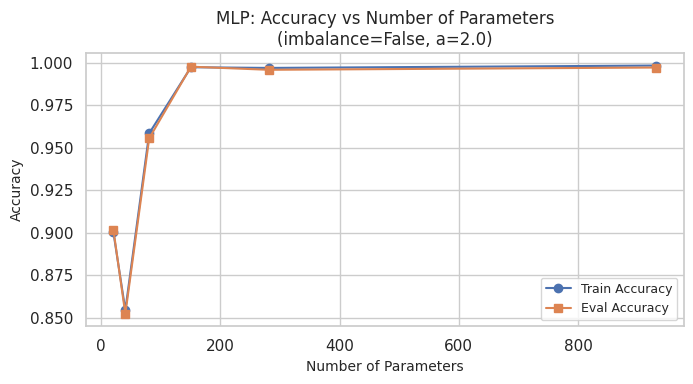


=== a = 2.0, imbalance = True ===


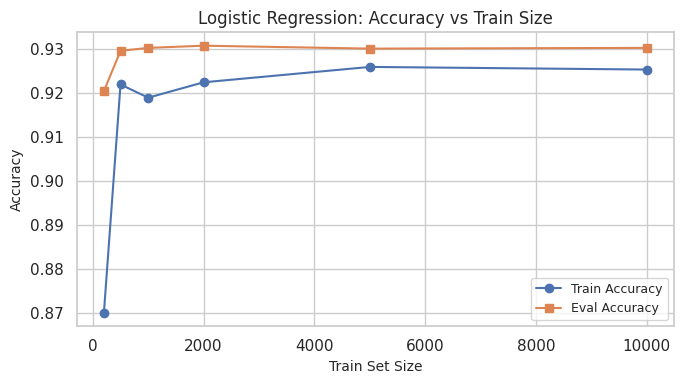

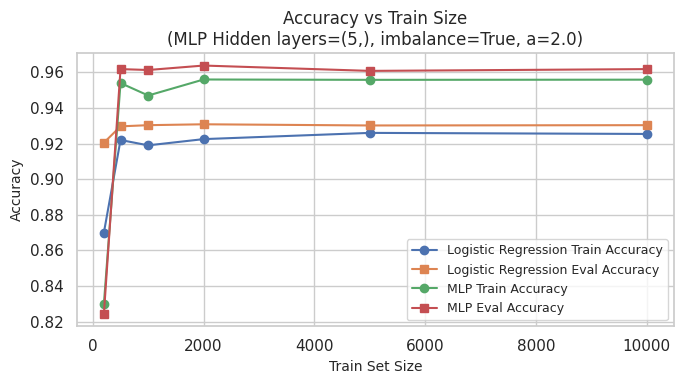

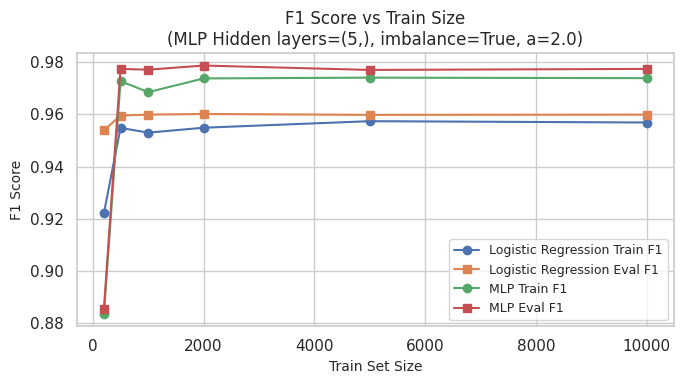

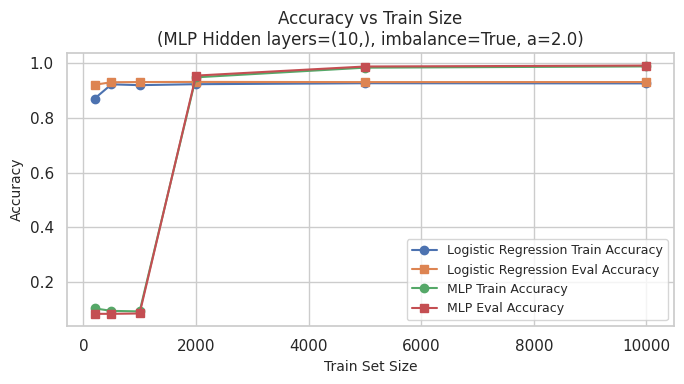

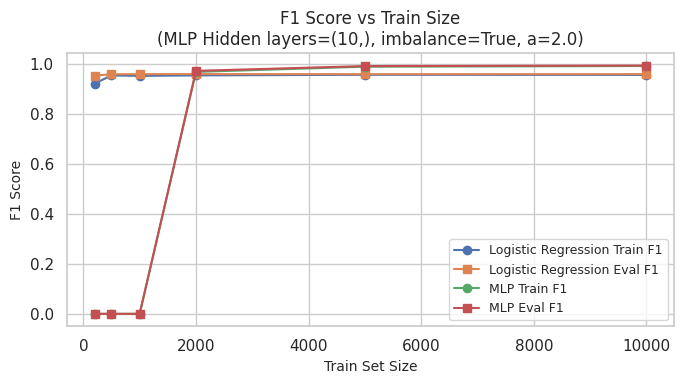

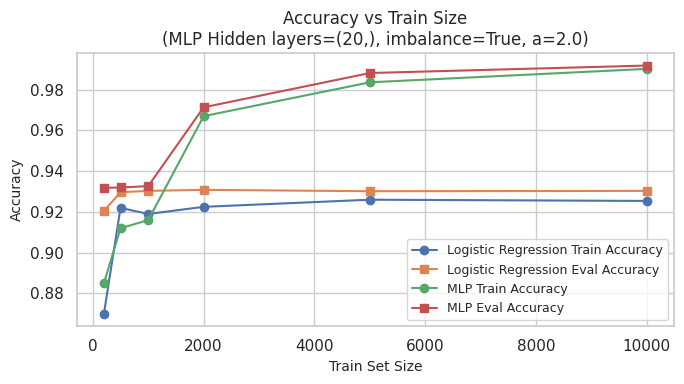

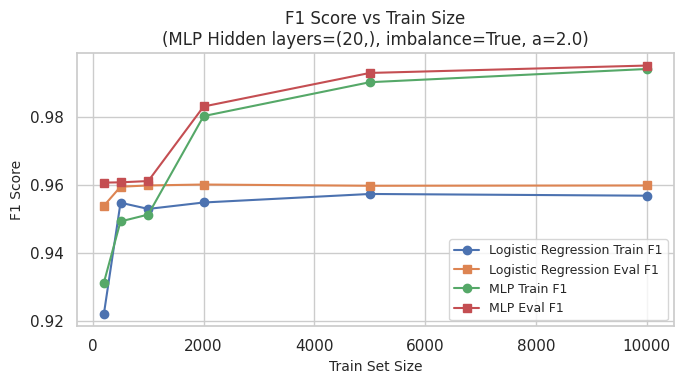

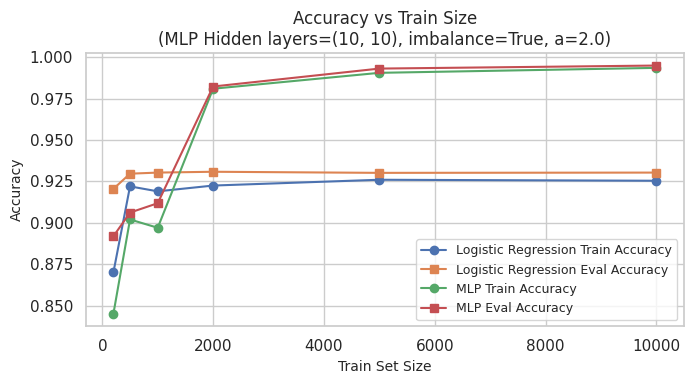

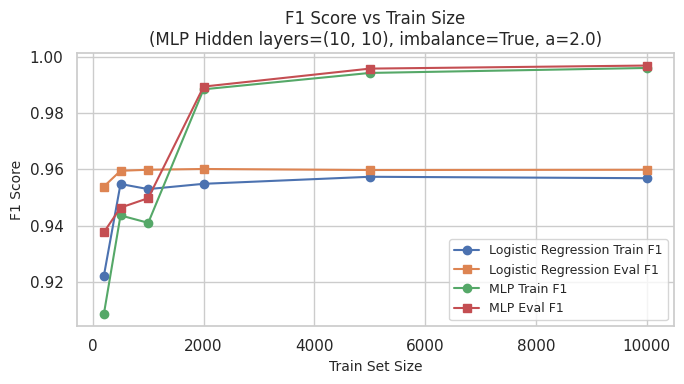

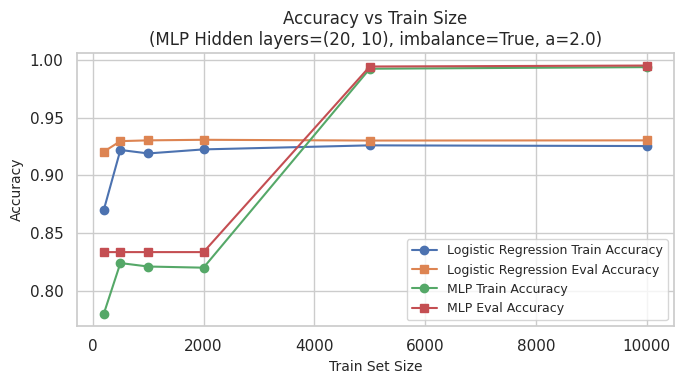

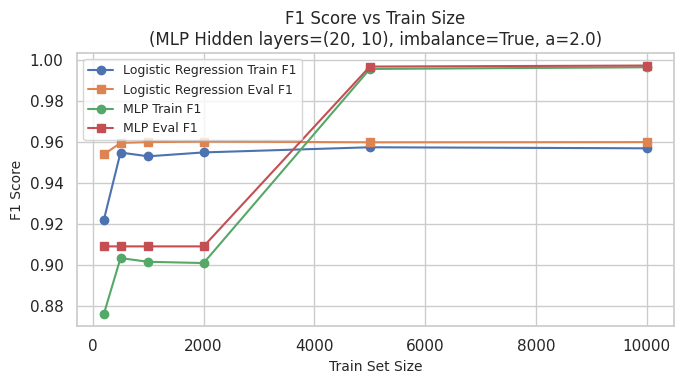

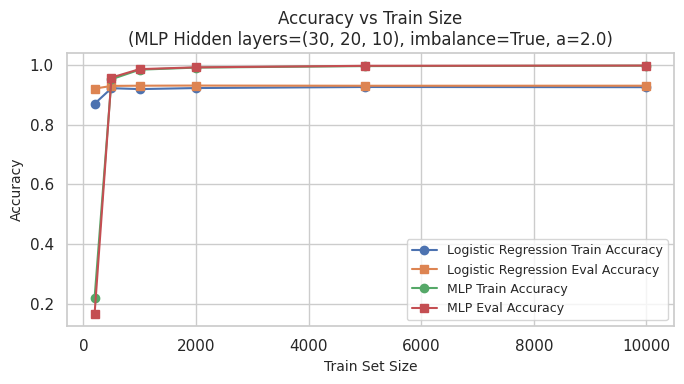

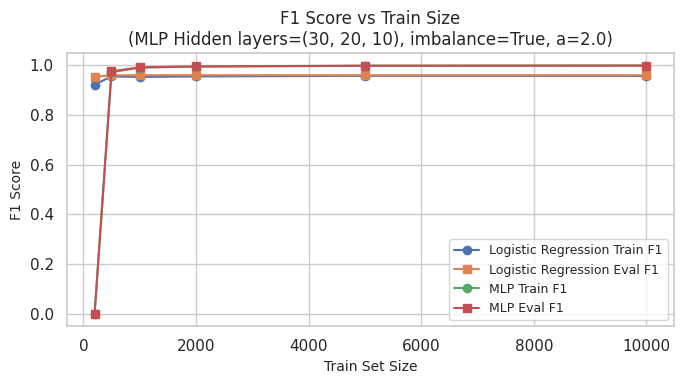

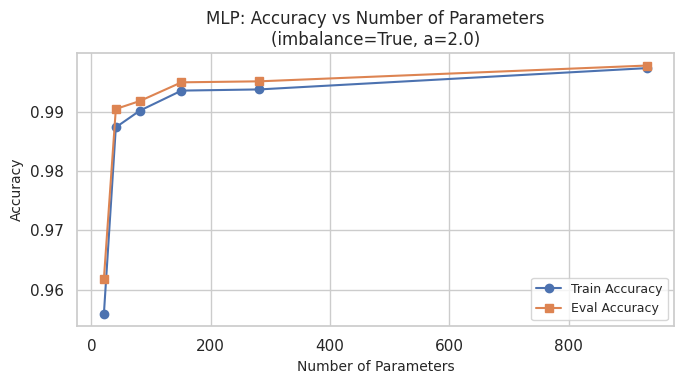

In [ ]:
plot_final_results(results_df)

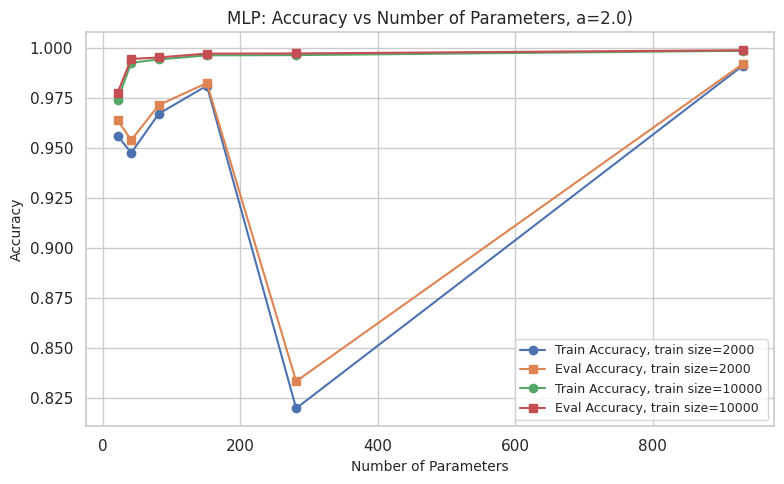

In [ ]:
imbalance = True
a = 2.0
train_size = 2000
mlp_df = results_df[
                (results_df['model'] == 'MLP') & (results_df['a'] == a) & (results_df['imbalance'] == imbalance) &
                (results_df['activation'] == 'relu') & (results_df['train_size'] == train_size)
            ]

plt.figure(figsize=(8, 5))
plt.plot(mlp_df['params'], mlp_df['train_accuracy'], marker='o', label=f'Train Accuracy, train size={train_size}')
plt.plot(mlp_df['params'], mlp_df['eval_accuracy'], marker='s', label=f'Eval Accuracy, train size={train_size}')

train_size = 10000
mlp_df = results_df[
                (results_df['model'] == 'MLP') & (results_df['a'] == a) & (results_df['imbalance'] == imbalance) &
                (results_df['activation'] == 'relu') & (results_df['train_size'] == train_size)
            ]
plt.plot(mlp_df['params'], mlp_df['train_f1'], marker='o', label=f'Train Accuracy, train size={train_size}')
plt.plot(mlp_df['params'], mlp_df['eval_f1'], marker='s', label=f'Eval Accuracy, train size={train_size}')


plt.title(f'MLP: Accuracy vs Number of Parameters, a={a})', fontsize=12)
plt.xlabel('Number of Parameters', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
imbalance = False
train_size = 200
logreg_df = results_df[ (results_df['model'] == 'LogisticRegression') & (results_df['imbalance'] == imbalance) & (results_df['train_size'] == train_size) ]
mlp_df = results_df[(results_df['model'] == 'MLP') & (results_df['train_size'] == train_size) & (results_df['imbalance'] == imbalance) & (results_df['hidden_layers'] == (20, )) & (results_df['activation'] == 'relu')]

plt.figure(figsize=(8, 5))
plt.plot(logreg_df['a'], logreg_df['eval_accuracy'], marker='o', label='Logistic Regression Eval Accuracy, train size=200')
plt.plot(mlp_df['a'], mlp_df['eval_accuracy'], marker='s', label='MLP Eval Accuracy, train size=200')

train_size = 1000
logreg_df = results_df[ (results_df['model'] == 'LogisticRegression') & (results_df['imbalance'] == imbalance) & (results_df['train_size'] == train_size) ]
mlp_df = results_df[(results_df['model'] == 'MLP') & (results_df['train_size'] == train_size) & (results_df['imbalance'] == imbalance) & (results_df['hidden_layers'] == (20, )) & (results_df['activation'] == 'relu')]
plt.plot(logreg_df['a'], logreg_df['eval_accuracy'], marker='o', label='Logistic Regression Eval Accuracy, train size=1000')
plt.plot(mlp_df['a'], mlp_df['eval_accuracy'], marker='s', label='MLP Eval Accuracy, train size=1000')


plt.title(f'Accuracy vs Curvature')
plt.xlabel('Curvature', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.legend()
plt.grid(True)
plt.legend(fontsize=9)
plt.show()

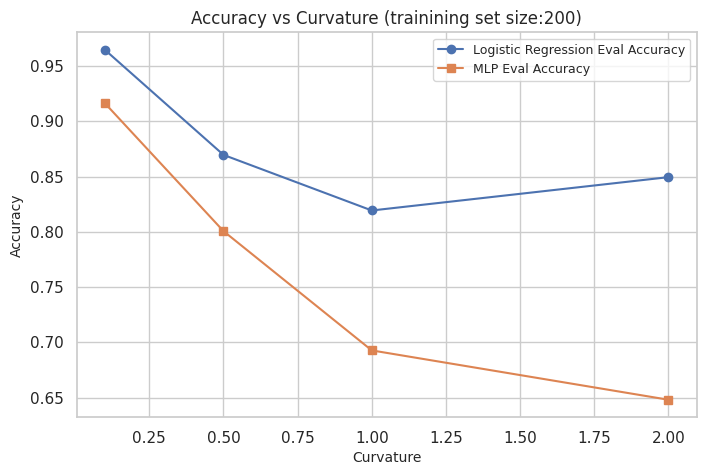

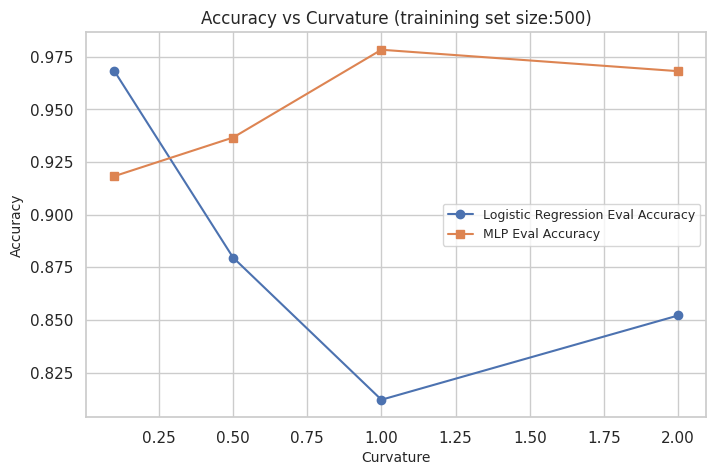

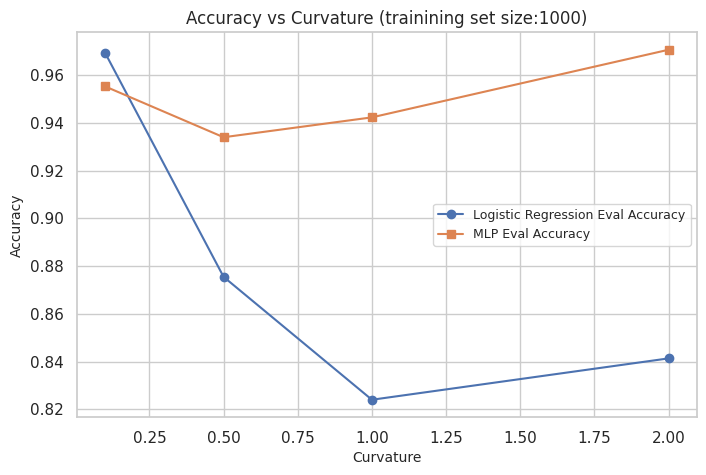

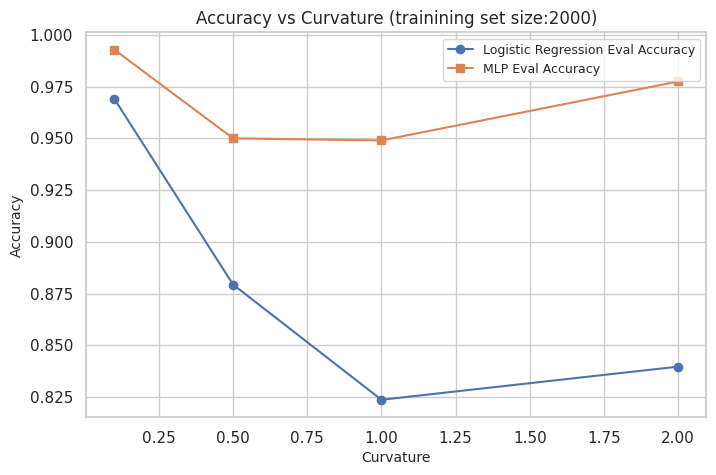

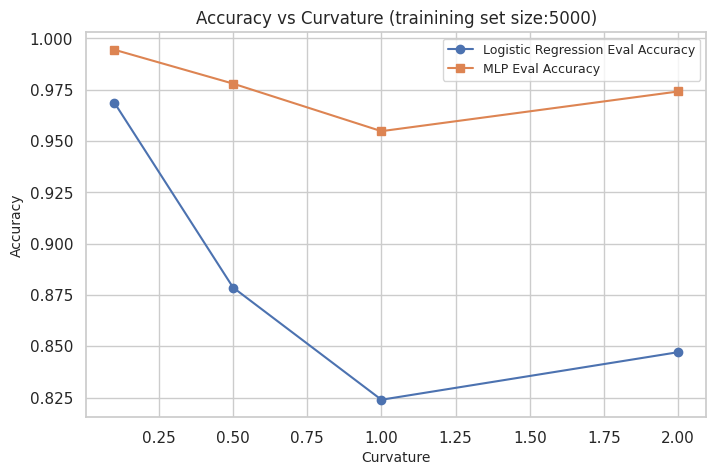

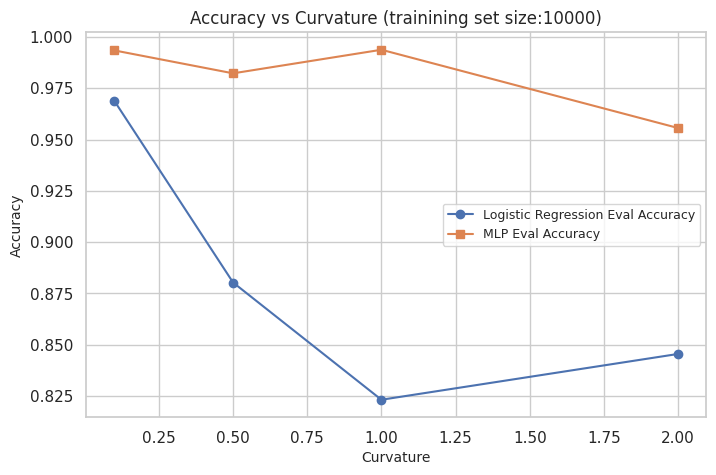

In [ ]:
for train_size in results_df['train_size'].unique():
    # for imbalance in results_df['imbalance'].unique():
      imbalance = False
      logreg_df = results_df[ (results_df['model'] == 'LogisticRegression') & (results_df['imbalance'] == imbalance) & (results_df['train_size'] == train_size) ]
      mlp_df = results_df[(results_df['model'] == 'MLP') & (results_df['train_size'] == train_size) & (results_df['imbalance'] == imbalance) & (results_df['hidden_layers'] == (20, )) & (results_df['activation'] == 'relu')]

      plt.figure(figsize=(8, 5))
      plt.plot(logreg_df['a'], logreg_df['eval_accuracy'], marker='o', label='Logistic Regression Eval Accuracy')
      plt.plot(mlp_df['a'], mlp_df['eval_accuracy'], marker='s', label='MLP Eval Accuracy')
      plt.title(f'Accuracy vs Curvature (trainining set size:{train_size})')
      plt.xlabel('Curvature', fontsize=10)
      plt.ylabel('Accuracy', fontsize=10)
      plt.legend()
      plt.grid(True)
      plt.legend(fontsize=9)
      plt.show()

        # plt.figure(figsize=(8, 5))
        # plt.plot(logreg_df['a'], logreg_df['train_f1'], marker='o', label='logreg Eval F1 Score')
        # plt.plot(mlp_df['a'], mlp_df['eval_f1'], marker='s', label='mlp Eval F1 Score')
        # plt.title(f'F1 vs Curvature (train size:{train_size}, imbalance:{imbalance})')
        # plt.xlabel('Curvature')
        # plt.ylabel('F1')
        # plt.legend()
        # plt.grid(True)
        # plt.show()

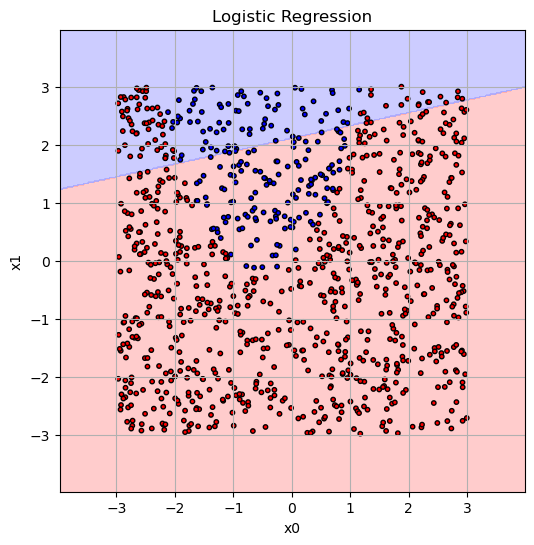

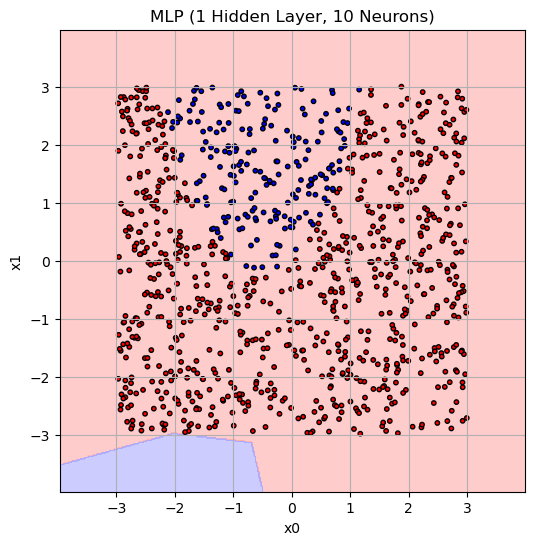

In [ ]:
# Generate a synthetic dataset with a non-linear decision boundary
X, y = generate_data(n_samples=1000, a=1.0)

# Fit two models on the data
_, model_log = evaluate_logistic(X, y)  # Train a logistic regression model and get the trained model
_, model_mlp = evaluate_mlp(X, y, hidden_layer_sizes=(10,))  # Train an MLP with 1 hidden layer of 10 neurons

# Plot the decision boundaries for both models
plot_decision_boundary(X, y, model_log, title="Logistic Regression")  # Plot for logistic regression
plot_decision_boundary(X, y, model_mlp, title="MLP (1 Hidden Layer, 10 Neurons)")  # Plot for MLP